In [1]:
import dask.array as da
import napari
import btrack
from tqdm.auto import tqdm
from skimage.io import imshow,  imsave, imread
import matplotlib.pyplot as plt
import numpy as np
import skimage as ski
import itertools
import json

plt.rcParams["figure.figsize"] = (15,7)

# Reloading images

In [2]:
%%time
image = imread('/mnt/DATA/sandbox/lung_on_chip/20220808_kolf-WT_co-culture_20x_A2-A5_Multichannel Z-Stack_20220808_57.vsi - 001 CF405, CF488, CF561, CF638.tif')
zo1 = image[...,3]
dapi = image[...,0]
pdpn = image[...,2]
spc = image[...,1]
apical_mask_stack = imread('/mnt/DATA/sandbox/lung_on_chip/pp_apical_masks.tif')
basal_mask_stack = imread('/mnt/DATA/sandbox/lung_on_chip/pp_basal_masks.tif')

CPU times: user 1.12 s, sys: 2.21 s, total: 3.32 s
Wall time: 3.83 s


In [4]:
image.shape

(81, 2304, 2304, 4)

### Defining properties to measure similarities of z-slices

In [5]:
props = ('axis_major_length', 
         'axis_minor_length', 
         'eccentricity', 
         'area', 
         'mean_intensity', 
         #'intensity_image', 
         'orientation')

In [6]:
%%time
apical_pdpn_objects = btrack.utils.segmentation_to_objects(
    apical_mask_stack, 
    pdpn,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
apical_pdpn_objects = [obj for obj in apical_pdpn_objects if obj.properties['area'] > 50]

[INFO][2022/09/15 10:27:03 AM] Localizing objects from segmentation...
[INFO][2022/09/15 10:27:03 AM] Found intensity_image data
[INFO][2022/09/15 10:27:03 AM] Calculating weighted centroids using intensity_image
[INFO][2022/09/15 10:27:26 AM] Objects are of type: <class 'dict'>
[INFO][2022/09/15 10:27:26 AM] ...Found 42052 objects in 81 frames.


CPU times: user 21 s, sys: 1.57 s, total: 22.5 s
Wall time: 22.5 s


In [7]:
%%time
basal_pdpn_objects = btrack.utils.segmentation_to_objects(
    basal_mask_stack, 
    pdpn,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
basal_pdpn_objects = [obj for obj in basal_pdpn_objects if obj.properties['area'] > 50]

[INFO][2022/09/15 10:27:26 AM] Localizing objects from segmentation...
[INFO][2022/09/15 10:27:26 AM] Found intensity_image data
[INFO][2022/09/15 10:27:26 AM] Calculating weighted centroids using intensity_image
[INFO][2022/09/15 10:27:33 AM] Objects are of type: <class 'dict'>
[INFO][2022/09/15 10:27:33 AM] ...Found 913 objects in 79 frames.


CPU times: user 1min 45s, sys: 3.71 s, total: 1min 49s
Wall time: 7.25 s


In [8]:
%%time
apical_spc_objects = btrack.utils.segmentation_to_objects(
    apical_mask_stack, 
    spc,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
apical_spc_objects = [obj for obj in apical_spc_objects if obj.properties['area'] > 50]

[INFO][2022/09/15 10:27:33 AM] Localizing objects from segmentation...
[INFO][2022/09/15 10:27:33 AM] Found intensity_image data
[INFO][2022/09/15 10:27:33 AM] Calculating weighted centroids using intensity_image
[INFO][2022/09/15 10:27:55 AM] Objects are of type: <class 'dict'>
[INFO][2022/09/15 10:27:55 AM] ...Found 42052 objects in 81 frames.


CPU times: user 23 s, sys: 1.57 s, total: 24.6 s
Wall time: 21.8 s


In [9]:
%%time
basal_spc_objects = btrack.utils.segmentation_to_objects(
    basal_mask_stack, 
    spc,
    properties = props#('area', 'mean_intensity', 'intensity_image'), 
)
basal_spc_objects = [obj for obj in basal_spc_objects if obj.properties['area'] > 50]

[INFO][2022/09/15 10:27:55 AM] Localizing objects from segmentation...
[INFO][2022/09/15 10:27:55 AM] Found intensity_image data
[INFO][2022/09/15 10:27:55 AM] Calculating weighted centroids using intensity_image
[INFO][2022/09/15 10:28:02 AM] Objects are of type: <class 'dict'>
[INFO][2022/09/15 10:28:02 AM] ...Found 913 objects in 79 frames.


CPU times: user 1min 36s, sys: 3.08 s, total: 1min 39s
Wall time: 6.46 s


##### Tracking apical objs

In [10]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(apical_pdpn_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  apical_pdpn_tracks = tracker.tracks
  # filter tracks
  apical_pdpn_tracks = [track for track in apical_pdpn_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  apical_pdpn_data, properties, graph = tracker.to_napari()
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(apical_spc_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  apical_spc_tracks = tracker.tracks
  # filter tracks
  apical_spc_tracks = [track for track in apical_spc_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  apical_spc_data, properties, graph = tracker.to_napari()

[INFO][2022/09/15 10:28:11 AM] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/09/15 10:28:11 AM] btrack (v0.4.5) library imported
[INFO][2022/09/15 10:28:11 AM] Starting BayesianTracker session
[INFO][2022/09/15 10:28:11 AM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/09/15 10:28:11 AM] Objects are of type: <class 'list'>
[INFO][2022/09/15 10:28:11 AM] Starting tracking... 
[INFO][2022/09/15 10:28:12 AM] Tracking objects in frames 0 to 81 (of 81)...
[INFO][2022/09/15 10:29:18 AM]  - Timing (Bayesian updates: 0.03ms, Linking: 0.07ms)
[INFO][2022/09/15 10:29:18 AM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/09/15 10:29:18 AM] SUCCESS.
[INFO][2022/09/15 10:29:18 AM]  - Found 5004 tracks in 81 frames (in 0.0s)
[INFO][2022/09/15 10:29:18 AM]  - Inserted 2969 dummy objects to fill tracking gaps
[INFO][2022/09/15 10:29:18 AM] Loading hypothesis model: 

GLPK Integer Optimizer 5.0
20016 rows, 16413 columns, 22818 non-zeros
16413 integer variables, all of which are binary
Preprocessing...
10008 rows, 16413 columns, 22818 non-zeros
16413 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 10008
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
10008 rows, 16413 columns, 22818 non-zeros
*     0: obj =   6.597361168e+04 inf =   0.000e+00 (3396)
Perturbing LP to avoid stalling [1085]...
Removing LP perturbation [3353]...
*  3353: obj =   4.657495723e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3353: mip =     not found yet >=              -inf        (1; 0)
+  3353: >>>>>   4.657495723e+04 >=   4.657495723e+04   0.0% (1; 0)
+  3353: mip =   4.657495723e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2022/09/15 10:29:20 AM] Ending BayesianTracker session
[INFO][2022/09/15 10:29:21 AM] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/09/15 10:29:21 AM] btrack (v0.4.5) library imported
[INFO][2022/09/15 10:29:21 AM] Starting BayesianTracker session
[INFO][2022/09/15 10:29:21 AM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/09/15 10:29:21 AM] Objects are of type: <class 'list'>
[INFO][2022/09/15 10:29:21 AM] Starting tracking... 
[INFO][2022/09/15 10:29:21 AM] Tracking objects in frames 0 to 81 (of 81)...
[INFO][2022/09/15 10:30:26 AM]  - Timing (Bayesian updates: 0.03ms, Linking: 0.06ms)
[INFO][2022/09/15 10:30:26 AM]  - Probabilities (Link: 1.00000, Lost: 1.00000)
[INFO][2022/09/15 10:30:26 AM] SUCCESS.
[INFO][2022/09/15 10:30:26 AM]  - Found 5001 tracks in 81 frames (in 0.0s)
[INFO][2022/09/15 10:30:26 AM]  - Inserted 2965 dummy objects to fill tracking 

GLPK Integer Optimizer 5.0
20004 rows, 16407 columns, 22812 non-zeros
16407 integer variables, all of which are binary
Preprocessing...
10002 rows, 16407 columns, 22812 non-zeros
16407 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 10002
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
10002 rows, 16407 columns, 22812 non-zeros
*     0: obj =   6.592216908e+04 inf =   0.000e+00 (3393)
Perturbing LP to avoid stalling [1074]...
Removing LP perturbation [3336]...
*  3336: obj =   4.661865138e+04 inf =   0.000e+00 (0) 1
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+  3336: mip =     not found yet >=              -inf        (1; 0)
+  3336: >>>>>   4.661865138e+04 >=   4.661865138e+04   0.0% (1; 0)
+  3336: mip =   4.661865138e+04 >=     tree is empty   0.0% (0; 1)
INTEGER O

[INFO][2022/09/15 10:30:29 AM] Ending BayesianTracker session


##### Tracking basal objects

In [23]:
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(basal_pdpn_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  basal_pdpn_tracks = tracker.tracks
  # filter tracks
  basal_pdpn_tracks = [track for track in basal_pdpn_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  basal_pdpn_data, properties, graph = tracker.to_napari()
# initialise a tracker session using a context manager
with btrack.BayesianTracker() as tracker:
  # configure the tracker using a config file
  tracker.configure('/home/dayn/analysis/BayesianTracker/models/particle_config.json')
  # append the objects to be tracked
  tracker.append(basal_spc_objects)
  # set the volume (Z axis volume limits default to [-1e5, 1e5] for 2D data)
  tracker.volume = ((0, 2304), (0, 2304))
  # track them (in interactive mode)
  tracker.track_interactive(step_size=100)
  # generate hypotheses and run the global optimizer
  tracker.optimize()
  # get the tracks as a python list
  basal_spc_tracks = tracker.tracks
  # filter tracks
  basal_spc_tracks = [track for track in basal_spc_tracks if len(track) >= 3]
  # optional: get the data in a format for napari
  basal_spc_data, properties, graph = tracker.to_napari()

[INFO][2022/09/15 11:05:23 AM] Loaded btrack: /home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/btrack/libs/libtracker.so
[INFO][2022/09/15 11:05:23 AM] btrack (v0.4.5) library imported
[INFO][2022/09/15 11:05:23 AM] Starting BayesianTracker session
[INFO][2022/09/15 11:05:23 AM] Loading configuration file: /home/dayn/analysis/BayesianTracker/models/particle_config.json
[INFO][2022/09/15 11:05:23 AM] Objects are of type: <class 'list'>
[INFO][2022/09/15 11:05:23 AM] Starting tracking... 
[INFO][2022/09/15 11:05:23 AM] Tracking objects in frames 0 to 79 (of 79)...
[INFO][2022/09/15 11:05:23 AM]  - Timing (Bayesian updates: 0.01ms, Linking: 0.02ms)
[INFO][2022/09/15 11:05:23 AM]  - Probabilities (Link: 0.99301, Lost: 1.00000)
[INFO][2022/09/15 11:05:23 AM] SUCCESS.
[INFO][2022/09/15 11:05:23 AM]  - Found 350 tracks in 79 frames (in 0.0s)
[INFO][2022/09/15 11:05:23 AM]  - Inserted 119 dummy objects to fill tracking gaps
[INFO][2022/09/15 11:05:23 AM] Loading hypothesis model: pa

GLPK Integer Optimizer 5.0
1400 rows, 1126 columns, 1552 non-zeros
1126 integer variables, all of which are binary
Preprocessing...
700 rows, 1126 columns, 1552 non-zeros
1126 integer variables, all of which are binary
Scaling...
 A: min|aij| =  1.000e+00  max|aij| =  1.000e+00  ratio =  1.000e+00
Problem data seem to be well scaled
Constructing initial basis...
Size of triangular part is 700
Solving LP relaxation...
GLPK Simplex Optimizer 5.0
700 rows, 1126 columns, 1552 non-zeros
*     0: obj =   4.595111432e+03 inf =   0.000e+00 (401)
*   425: obj =   1.697624208e+03 inf =   0.000e+00 (0)
OPTIMAL LP SOLUTION FOUND
Integer optimization begins...
Long-step dual simplex will be used
+   425: mip =     not found yet >=              -inf        (1; 0)
+   425: >>>>>   1.697624208e+03 >=   1.697624208e+03   0.0% (1; 0)
+   425: mip =   1.697624208e+03 >=     tree is empty   0.0% (0; 1)
INTEGER OPTIMAL SOLUTION FOUND
GLPK Integer Optimizer 5.0
1424 rows, 1151 columns, 1590 non-zeros
1151 i

[INFO][2022/09/15 11:05:23 AM]  - Fates.FALSE_POSITIVE: 320 (of 356)
[INFO][2022/09/15 11:05:23 AM]  - Fates.LINK: 9 (of 83)
[INFO][2022/09/15 11:05:23 AM]  - Fates.INITIALIZE_FRONT: 1 (of 8)
[INFO][2022/09/15 11:05:23 AM]  - Fates.INITIALIZE_LAZY: 26 (of 348)
[INFO][2022/09/15 11:05:23 AM]  - Fates.TERMINATE_BACK: 2 (of 7)
[INFO][2022/09/15 11:05:23 AM]  - Fates.TERMINATE_LAZY: 25 (of 349)
[INFO][2022/09/15 11:05:23 AM]  - TOTAL: 1151 hypotheses
[INFO][2022/09/15 11:05:23 AM] Completed optimization with 347 tracks
[INFO][2022/09/15 11:05:23 AM] Ending BayesianTracker session


In [12]:
apical_pdpn_tracks[45]

OrderedDict([('ID', 70), ('t', [12, 13, 14, 15, 16, 17, 18]), ('x', [2178.6897326729313, 2178.6897326729313, 2178.9849350564423, 2167.119385530514, 2160.9081685022334, 2152.5757209214216, 2124.4972079655104]), ('y', [1474.9336007734844, 1474.9336007734844, 1462.4247284141347, 1448.3623796254856, 1428.381467251089, 1414.9927708467105, 1409.3088688154382]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, -4.447639798604544, 0.0]), ('parent', 70), ('root', 70), ('state', [5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, True, False, False, False, True, False]), ('mean_intensity', array([127.19309601,          nan, 127.96757322, 126.50776256,
       125.70880558,          nan, 178.09872029])), ('axis_minor_length', array([24.38345975,         nan, 29.28464349, 25.93995455, 34.21665741,
               nan, 24.99152966])), ('area', array([ 927.,   nan,  956., 1095., 1147.,   nan,  547.])), ('orientation', array([ 0.4321525 ,         nan,  0.52428486,  0.69371405,  0.49781556,
               nan, -1.49903227])), ('axis_major_length', array([50.50985099,         nan, 42.53096912, 60.02681486, 43.3775947 ,
               nan, 29.96648037])), ('eccentricity', array([0.87576007,        nan, 0.7251901 , 0.9018068 , 0.6146378 ,
              nan, 0.55179042]))])

In [13]:
apical_spc_tracks[45]

OrderedDict([('ID', 70), ('t', [12, 13, 14, 15, 16, 17, 18]), ('x', [2178.498789171215, 2178.498789171215, 2178.814613810873, 2167.0497245394704, 2160.6639170500266, 2152.251607795324, 2124.4188990919815]), ('y', [1474.6376188238696, 1474.6376188238696, 1462.3237688429306, 1448.3727402172374, 1428.421866662821, 1415.023999072723, 1409.3084081465142]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, -4.493264188756895, 0.0]), ('parent', 70), ('root', 70), ('state', [5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, True, False, False, False, True, False]), ('mean_intensity', array([119.38295577,          nan, 122.19769874, 122.50136986,
       120.9119442 ,          nan, 178.1809872 ])), ('axis_minor_length', array([24.38345975,         nan, 29.28464349, 25.93995455, 34.21665741,
               nan, 24.99152966])), ('area', array([ 927.,   nan,  956., 1095., 1147.,   nan,  547.])), ('orientation', array([ 0.4321525 ,         nan,  0.52428486,  0.69371405,  0.49781556,
               nan, -1.49903227])), ('axis_major_length', array([50.50985099,         nan, 42.53096912, 60.02681486, 43.3775947 ,
               nan, 29.96648037])), ('eccentricity', array([0.87576007,        nan, 0.7251901 , 0.9018068 , 0.6146378 ,
              nan, 0.55179042]))])

#### Eliminating tracks that have dummy figures in them

Because these contain n/a intensity measures

In [27]:
spc_apical_dummy_count = 0
pdpn_apical_dummy_count = 0
spc_apical_tracks_final, pdpn_apical_tracks_final = [], []
for spc_track, pdpn_track in zip(apical_pdpn_tracks, apical_spc_tracks):
    if any(spc_track.dummy) == True:
        spc_apical_dummy_count+=1
    else:
        spc_apical_tracks_final.append(spc_track)
    if any(pdpn_track.dummy) == True:
        pdpn_apical_dummy_count+=1
    else:    
        pdpn_apical_tracks_final.append(pdpn_track)
#     for prop in spc_track.properties:
#         if (spc_track.properties[prop] != pdpn_track.properties[prop]).all():
#             print(spc_track.ID, prop)
spc_basal_dummy_count = 0
pdpn_basal_dummy_count = 0
spc_basal_tracks_final, pdpn_basal_tracks_final = [], []
for spc_track, pdpn_track in zip(basal_pdpn_tracks, basal_spc_tracks):
    if any(spc_track.dummy) == True:
        spc_basal_dummy_count+=1
    else:
        spc_basal_tracks_final.append(spc_track)
    if any(pdpn_track.dummy) == True:
        pdpn_basal_dummy_count+=1
    else:    
        pdpn_basal_tracks_final.append(pdpn_track)

In [30]:
len(apical_spc_tracks), len(apical_pdpn_tracks), spc_apical_dummy_count, pdpn_apical_dummy_count

(3378, 3370, 1046, 1026)

In [31]:
len(basal_spc_tracks), len(basal_pdpn_tracks), spc_basal_dummy_count, pdpn_basal_dummy_count

(111, 105, 65, 68)

In [16]:
pdpn_tracks_final[0]

OrderedDict([('ID', 15), ('t', [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]), ('x', [2287.846447875798, 2291.462403753609, 2288.4453878777167, 2289.406991220727, 2288.9680615661778, 2289.141497144002, 2290.126537123832, 2290.151590889121, 2290.513728084684, 2290.548953415953, 2290.1790644373473, 2290.1014405971273, 2290.437980825441, 2290.357911800575, 2290.6735317943344, 2290.2228737578157, 2290.114668455144, 2290.5179555678956, 2290.0081667947734]), ('y', [1663.5144644450806, 1661.8067853705486, 1659.8921717617955, 1661.1475089617275, 1660.9476667906868, 1664.2197698500183, 1662.7678831538165, 1662.9699493297667, 1662.692575965219, 1662.1134228127341, 1661.711764042833, 1662.3405699723578, 1662.088898632059, 1663.0577506988602, 1663.0414367569906, 1662.6153909400425, 1662.344824299758, 1662.803863889629, 1660.1331362238836]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 15), ('root', 15), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]), ('mean_intensity', array([113.55066922, 114.49035813, 115.0203252 , 117.2       ,
       118.21064815, 120.71370968, 125.20967742, 129.49051833,
       137.94654498, 147.52197071, 163.28220859, 183.65856777,
       215.16981132, 262.175     , 302.67137356, 325.91108404,
       329.03019744, 313.92108363, 292.80818414])), ('axis_minor_length', array([32.05045915, 26.25095786, 34.25041454, 31.15518408, 30.99650995,
       33.75120508, 31.30496854, 31.24353653, 30.67890942, 30.55978047,
       31.7638422 , 30.71670096, 31.23548   , 31.52763438, 31.05541375,
       32.26219436, 33.0535803 , 30.77198569, 31.33006407])), ('area', array([1046,  726,  984,  795,  864,  992,  806,  791,  767,  751,  815,
        782,  795,  760,  779,  821,  861,  849,  782])), ('orientation', array([ 0.51572282,  0.21915897, -0.15979834, -0.57431891,  0.53997529,
        0.49566633,  0.31134445,  0.57334449,  0.29942966,  0.42805505,
        0.24236303,  0.60069258,  0.32325198,  0.72855494,  0.40279036,
        0.30873108,  0.78862885,  0.51754389,  0.96243723])), ('axis_major_length', array([43.71397496, 37.10244147, 38.25185439, 34.0129479 , 36.86571196,
       42.30866445, 35.13980903, 35.7616597 , 34.34604621, 33.76724626,
       35.3282082 , 34.59371735, 34.69685634, 33.3016402 , 34.50869542,
       35.02036921, 35.45614181, 39.44537019, 35.96934649])), ('eccentricity', array([0.68002853, 0.70668689, 0.44527822, 0.40122365, 0.54135349,
       0.60300497, 0.45426019, 0.4865367 , 0.44960055, 0.42538494,
       0.43772875, 0.4599841 , 0.43539508, 0.32203085, 0.43603419,
       0.38899269, 0.36184442, 0.62563423, 0.49124539]))])

In [21]:
spc_tracks_final[0]

OrderedDict([('ID', 15), ('t', [7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]), ('x', [2287.795727864827, 2291.3959194065433, 2288.370132360587, 2289.322178874679, 2288.8239623309632, 2288.9263776634825, 2289.9486202014, 2289.9556285708713, 2290.30971977458, 2290.3677699484388, 2289.8869867935678, 2289.716236826452, 2290.0028115015975, 2289.910075636145, 2290.2459998714817, 2289.807354971252, 2289.4281138079436, 2289.8515391388496, 2289.1587307801474]), ('y', [1663.5439776229234, 1661.7649203208, 1659.825604486453, 1661.0568084618112, 1660.9414483821263, 1664.1927749204017, 1662.657510916598, 1662.9181990133181, 1662.6515095764664, 1661.9300974144464, 1661.7046917168361, 1662.2623652142083, 1661.922179250042, 1662.9875713784813, 1662.9267928286852, 1662.5216015096655, 1662.0952293959954, 1662.391715414055, 1659.7224902860835]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 15), ('root', 15), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]), ('mean_intensity', array([117.57456979, 119.02066116, 119.23882114, 120.58616352,
       120.93634259, 123.47782258, 125.30148883, 129.66624526,
       134.64667536, 142.2942743 , 153.67116564, 167.69053708,
       187.01257862, 210.14736842, 239.72272144, 262.05481121,
       273.3786295 , 270.21672556, 261.31202046])), ('axis_minor_length', array([32.05045915, 26.25095786, 34.25041454, 31.15518408, 30.99650995,
       33.75120508, 31.30496854, 31.24353653, 30.67890942, 30.55978047,
       31.7638422 , 30.71670096, 31.23548   , 31.52763438, 31.05541375,
       32.26219436, 33.0535803 , 30.77198569, 31.33006407])), ('area', array([1046,  726,  984,  795,  864,  992,  806,  791,  767,  751,  815,
        782,  795,  760,  779,  821,  861,  849,  782])), ('orientation', array([ 0.51572282,  0.21915897, -0.15979834, -0.57431891,  0.53997529,
        0.49566633,  0.31134445,  0.57334449,  0.29942966,  0.42805505,
        0.24236303,  0.60069258,  0.32325198,  0.72855494,  0.40279036,
        0.30873108,  0.78862885,  0.51754389,  0.96243723])), ('axis_major_length', array([43.71397496, 37.10244147, 38.25185439, 34.0129479 , 36.86571196,
       42.30866445, 35.13980903, 35.7616597 , 34.34604621, 33.76724626,
       35.3282082 , 34.59371735, 34.69685634, 33.3016402 , 34.50869542,
       35.02036921, 35.45614181, 39.44537019, 35.96934649])), ('eccentricity', array([0.68002853, 0.70668689, 0.44527822, 0.40122365, 0.54135349,
       0.60300497, 0.45426019, 0.4865367 , 0.44960055, 0.42538494,
       0.43772875, 0.4599841 , 0.43539508, 0.32203085, 0.43603419,
       0.38899269, 0.36184442, 0.62563423, 0.49124539]))])

In [22]:
len(spc_tracks_final)

2324

In [18]:
[track for track in spc_tracks_final if track.ID == 2549][0]

OrderedDict([('ID', 2549), ('t', [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]), ('x', [904.7490239486533, 905.6169321736816, 905.0510685801132, 905.4454596733566, 904.8985050886733, 904.6882032519113, 904.8579127467968, 905.1518126765374, 905.0780830299201, 905.1063997998086, 905.5307306381601, 905.038076076551, 905.8720869203978, 906.3068198158361, 906.057529901036, 905.5163787024851, 904.6383199149789, 904.767680903477, 904.85133741769, 906.1112119462091]), ('y', [775.1569490565552, 773.617303809545, 772.9553783181576, 772.1999603859783, 771.6520768488577, 771.8638988658549, 772.394422417578, 772.6470092328044, 772.8026098556655, 772.5680155753303, 772.0736127774597, 771.3849047082182, 771.1804430959596, 771.7260094471299, 771.7629524735146, 772.0437569046176, 772.8815457485607, 772.4598463459354, 772.101254221199, 773.2741660479059]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 2549), ('root', 2549), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]), ('mean_intensity', array([127.64622125, 133.44485566, 136.25717776, 143.62461348,
       153.66439206, 169.22824716, 196.42725477, 249.59539919,
       341.90329218, 497.47195622, 678.07596685, 762.37103746,
       700.26753247, 557.86308806, 441.24644243, 359.17734282,
       295.07275804, 244.09939594, 208.06015891, 192.56663725])), ('axis_minor_length', array([31.18445802, 40.12621144, 45.28017743, 43.44251081, 42.55736759,
       41.80887129, 41.29914215, 41.09937995, 40.88626689, 40.81370445,
       41.39148135, 40.03215109, 41.26528242, 42.23796502, 41.3860422 ,
       43.93247577, 44.90430358, 45.7158474 , 44.81297426, 34.99535193])), ('area', array([ 913, 1351, 1637, 1617, 1612, 1586, 1519, 1478, 1458, 1462, 1448,
       1388, 1540, 1658, 1546, 1686, 1773, 1821, 1762, 1133])), ('orientation', array([ 0.0947897 ,  0.03487542, -0.09383499,  0.26101045,  0.32978459,
        0.45392238,  0.51132205,  0.34346978,  0.2806975 ,  0.36980111,
        0.52525046,  0.17627347,  0.38325778,  0.45826565,  0.48650718,
        0.35892945,  0.45303987,  0.4607    ,  0.45202176, -0.6047985 ])), ('axis_major_length', array([37.48182443, 43.00542306, 46.55697327, 48.18662656, 49.16535962,
       49.59465239, 48.17059187, 46.98528292, 46.43553639, 46.61418182,
       45.6016365 , 45.34153106, 48.70730005, 51.15177802, 48.69360315,
       50.0167    , 51.48954998, 51.43138223, 50.40857915, 41.41414439])), ('eccentricity', array([0.55479243, 0.35974662, 0.23258687, 0.43268109, 0.50074199,
       0.53789526, 0.51473094, 0.48461277, 0.47405506, 0.48310195,
       0.41967304, 0.46955636, 0.5312591 , 0.56405391, 0.52689933,
       0.47800678, 0.48931845, 0.45815819, 0.45791692, 0.53475105]))])

In [20]:
len(spc_tracks_final)

2324

## Checking tracks prior to plotting single cell info

In [19]:
import napari

In [36]:
viewer = napari.Viewer()

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_viewer.py:1068: UserWarning: No readers found to try reading /run/user/30046150/gvfs/smb-share:server=data.thecrick.org,share=lab-gutierrezm/home/shared/Lung on chip/Light microscopy/mono-culture/iAT2AT1/21-12-031B_day7_static_20220530/20x_21-12-031B_A12456_Multichannel Z-Stack_20220811_113.vsi.
  warnings.warn(
Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/qt_viewer.py", line 1094, in dropEvent
    self._get_and_try_p

Rendering frame  1 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
[swscaler @ 0x588dec0] Warning: data is not ali

Rendering frame  2 of 199
Rendering frame  3 of 199
Rendering frame  4 of 199
Rendering frame  5 of 199
Rendering frame  6 of 199
Rendering frame  7 of 199
Rendering frame  8 of 199
Rendering frame  9 of 199
Rendering frame  10 of 199
Rendering frame  11 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  12 of 199
Rendering frame  13 of 199
Rendering frame  14 of 199
Rendering frame  15 of 199
Rendering frame  16 of 199
Rendering frame  17 of 199
Rendering frame  18 of 199
Rendering frame  19 of 199
Rendering frame  20 of 199
Rendering frame  21 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  22 of 199
Rendering frame  23 of 199
Rendering frame  24 of 199
Rendering frame  25 of 199
Rendering frame  26 of 199
Rendering frame  27 of 199
Rendering frame  28 of 199
Rendering frame  29 of 199
Rendering frame  30 of 199
Rendering frame  31 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  32 of 199
Rendering frame  33 of 199
Rendering frame  34 of 199
Rendering frame  35 of 199
Rendering frame  36 of 199
Rendering frame  37 of 199
Rendering frame  38 of 199
Rendering frame  39 of 199
Rendering frame  40 of 199
Rendering frame  41 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  42 of 199
Rendering frame  43 of 199
Rendering frame  44 of 199
Rendering frame  45 of 199
Rendering frame  46 of 199
Rendering frame  47 of 199
Rendering frame  48 of 199
Rendering frame  49 of 199
Rendering frame  50 of 199
Rendering frame  51 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  52 of 199
Rendering frame  53 of 199
Rendering frame  54 of 199
Rendering frame  55 of 199
Rendering frame  56 of 199
Rendering frame  57 of 199
Rendering frame  58 of 199
Rendering frame  59 of 199
Rendering frame  60 of 199
Rendering frame  61 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  62 of 199
Rendering frame  63 of 199
Rendering frame  64 of 199
Rendering frame  65 of 199
Rendering frame  66 of 199
Rendering frame  67 of 199
Rendering frame  68 of 199
Rendering frame  69 of 199
Rendering frame  70 of 199
Rendering frame  71 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  72 of 199
Rendering frame  73 of 199
Rendering frame  74 of 199
Rendering frame  75 of 199
Rendering frame  76 of 199
Rendering frame  77 of 199
Rendering frame  78 of 199
Rendering frame  79 of 199
Rendering frame  80 of 199
Rendering frame  81 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  82 of 199
Rendering frame  83 of 199
Rendering frame  84 of 199
Rendering frame  85 of 199
Rendering frame  86 of 199
Rendering frame  87 of 199
Rendering frame  88 of 199
Rendering frame  89 of 199
Rendering frame  90 of 199
Rendering frame  91 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  92 of 199
Rendering frame  93 of 199
Rendering frame  94 of 199
Rendering frame  95 of 199
Rendering frame  96 of 199
Rendering frame  97 of 199
Rendering frame  98 of 199
Rendering frame  99 of 199
Rendering frame  100 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  101 of 199
Rendering frame  102 of 199
Rendering frame  103 of 199
Rendering frame  104 of 199
Rendering frame  105 of 199
Rendering frame  106 of 199
Rendering frame  107 of 199
Rendering frame  108 of 199
Rendering frame  109 of 199
Rendering frame  110 of 199
Rendering frame  111 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  112 of 199
Rendering frame  113 of 199
Rendering frame  114 of 199
Rendering frame  115 of 199
Rendering frame  116 of 199
Rendering frame  117 of 199
Rendering frame  118 of 199
Rendering frame  119 of 199
Rendering frame  120 of 199
Rendering frame  121 of 199
Rendering frame  122 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  123 of 199
Rendering frame  124 of 199
Rendering frame  125 of 199
Rendering frame  126 of 199
Rendering frame  127 of 199
Rendering frame  128 of 199
Rendering frame  129 of 199
Rendering frame  130 of 199
Rendering frame  131 of 199
Rendering frame  132 of 199
Rendering frame  133 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  134 of 199
Rendering frame  135 of 199
Rendering frame  136 of 199
Rendering frame  137 of 199
Rendering frame  138 of 199
Rendering frame  139 of 199
Rendering frame  140 of 199
Rendering frame  141 of 199
Rendering frame  142 of 199
Rendering frame  143 of 199
Rendering frame  144 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  145 of 199
Rendering frame  146 of 199
Rendering frame  147 of 199
Rendering frame  148 of 199
Rendering frame  149 of 199
Rendering frame  150 of 199
Rendering frame  151 of 199
Rendering frame  152 of 199
Rendering frame  153 of 199
Rendering frame  154 of 199
Rendering frame  155 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  156 of 199
Rendering frame  157 of 199
Rendering frame  158 of 199
Rendering frame  159 of 199
Rendering frame  160 of 199
Rendering frame  161 of 199
Rendering frame  162 of 199
Rendering frame  163 of 199
Rendering frame  164 of 199
Rendering frame  165 of 199
Rendering frame  166 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  167 of 199
Rendering frame  168 of 199
Rendering frame  169 of 199
Rendering frame  170 of 199
Rendering frame  171 of 199
Rendering frame  172 of 199
Rendering frame  173 of 199
Rendering frame  174 of 199
Rendering frame  175 of 199
Rendering frame  176 of 199
Rendering frame  177 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  178 of 199
Rendering frame  179 of 199
Rendering frame  180 of 199
Rendering frame  181 of 199
Rendering frame  182 of 199
Rendering frame  183 of 199
Rendering frame  184 of 199
Rendering frame  185 of 199
Rendering frame  186 of 199
Rendering frame  187 of 199
Rendering frame  188 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  189 of 199
Rendering frame  190 of 199
Rendering frame  191 of 199
Rendering frame  192 of 199
Rendering frame  193 of 199
Rendering frame  194 of 199
Rendering frame  195 of 199
Rendering frame  196 of 199
Rendering frame  197 of 199
Rendering frame  198 of 199
Rendering frame  199 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  1 of 199
Rendering frame  2 of 199


[swscaler @ 0x6147ec0] Warning: data is not aligned! This can lead to a speed loss


Rendering frame  3 of 199
Rendering frame  4 of 199
Rendering frame  5 of 199
Rendering frame  6 of 199
Rendering frame  7 of 199
Rendering frame  8 of 199
Rendering frame  9 of 199
Rendering frame  10 of 199
Rendering frame  11 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  12 of 199
Rendering frame  13 of 199
Rendering frame  14 of 199
Rendering frame  15 of 199
Rendering frame  16 of 199
Rendering frame  17 of 199
Rendering frame  18 of 199
Rendering frame  19 of 199
Rendering frame  20 of 199
Rendering frame  21 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  22 of 199
Rendering frame  23 of 199
Rendering frame  24 of 199
Rendering frame  25 of 199
Rendering frame  26 of 199
Rendering frame  27 of 199
Rendering frame  28 of 199
Rendering frame  29 of 199
Rendering frame  30 of 199
Rendering frame  31 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  32 of 199
Rendering frame  33 of 199
Rendering frame  34 of 199
Rendering frame  35 of 199
Rendering frame  36 of 199
Rendering frame  37 of 199
Rendering frame  38 of 199
Rendering frame  39 of 199
Rendering frame  40 of 199
Rendering frame  41 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  42 of 199
Rendering frame  43 of 199
Rendering frame  44 of 199
Rendering frame  45 of 199
Rendering frame  46 of 199
Rendering frame  47 of 199
Rendering frame  48 of 199
Rendering frame  49 of 199
Rendering frame  50 of 199
Rendering frame  51 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  52 of 199
Rendering frame  53 of 199
Rendering frame  54 of 199
Rendering frame  55 of 199
Rendering frame  56 of 199
Rendering frame  57 of 199
Rendering frame  58 of 199
Rendering frame  59 of 199
Rendering frame  60 of 199
Rendering frame  61 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  62 of 199
Rendering frame  63 of 199
Rendering frame  64 of 199
Rendering frame  65 of 199
Rendering frame  66 of 199
Rendering frame  67 of 199
Rendering frame  68 of 199
Rendering frame  69 of 199
Rendering frame  70 of 199
Rendering frame  71 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  72 of 199
Rendering frame  73 of 199
Rendering frame  74 of 199
Rendering frame  75 of 199
Rendering frame  76 of 199
Rendering frame  77 of 199
Rendering frame  78 of 199
Rendering frame  79 of 199
Rendering frame  80 of 199
Rendering frame  81 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  82 of 199
Rendering frame  83 of 199
Rendering frame  84 of 199
Rendering frame  85 of 199
Rendering frame  86 of 199
Rendering frame  87 of 199
Rendering frame  88 of 199
Rendering frame  89 of 199
Rendering frame  90 of 199
Rendering frame  91 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  92 of 199
Rendering frame  93 of 199
Rendering frame  94 of 199
Rendering frame  95 of 199
Rendering frame  96 of 199
Rendering frame  97 of 199
Rendering frame  98 of 199
Rendering frame  99 of 199
Rendering frame  100 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  101 of 199
Rendering frame  102 of 199
Rendering frame  103 of 199
Rendering frame  104 of 199
Rendering frame  105 of 199
Rendering frame  106 of 199
Rendering frame  107 of 199
Rendering frame  108 of 199
Rendering frame  109 of 199
Rendering frame  110 of 199
Rendering frame  111 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  112 of 199
Rendering frame  113 of 199
Rendering frame  114 of 199
Rendering frame  115 of 199
Rendering frame  116 of 199
Rendering frame  117 of 199
Rendering frame  118 of 199
Rendering frame  119 of 199
Rendering frame  120 of 199
Rendering frame  121 of 199
Rendering frame  122 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  123 of 199
Rendering frame  124 of 199
Rendering frame  125 of 199
Rendering frame  126 of 199
Rendering frame  127 of 199
Rendering frame  128 of 199
Rendering frame  129 of 199
Rendering frame  130 of 199
Rendering frame  131 of 199
Rendering frame  132 of 199
Rendering frame  133 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  134 of 199
Rendering frame  135 of 199
Rendering frame  136 of 199
Rendering frame  137 of 199
Rendering frame  138 of 199
Rendering frame  139 of 199
Rendering frame  140 of 199
Rendering frame  141 of 199
Rendering frame  142 of 199
Rendering frame  143 of 199
Rendering frame  144 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  145 of 199
Rendering frame  146 of 199
Rendering frame  147 of 199
Rendering frame  148 of 199
Rendering frame  149 of 199
Rendering frame  150 of 199
Rendering frame  151 of 199
Rendering frame  152 of 199
Rendering frame  153 of 199
Rendering frame  154 of 199
Rendering frame  155 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  156 of 199
Rendering frame  157 of 199
Rendering frame  158 of 199
Rendering frame  159 of 199
Rendering frame  160 of 199
Rendering frame  161 of 199
Rendering frame  162 of 199
Rendering frame  163 of 199
Rendering frame  164 of 199
Rendering frame  165 of 199
Rendering frame  166 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  167 of 199
Rendering frame  168 of 199
Rendering frame  169 of 199
Rendering frame  170 of 199
Rendering frame  171 of 199
Rendering frame  172 of 199
Rendering frame  173 of 199
Rendering frame  174 of 199
Rendering frame  175 of 199
Rendering frame  176 of 199
Rendering frame  177 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  178 of 199
Rendering frame  179 of 199
Rendering frame  180 of 199
Rendering frame  181 of 199
Rendering frame  182 of 199
Rendering frame  183 of 199
Rendering frame  184 of 199
Rendering frame  185 of 199
Rendering frame  186 of 199
Rendering frame  187 of 199
Rendering frame  188 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  189 of 199
Rendering frame  190 of 199
Rendering frame  191 of 199
Rendering frame  192 of 199
Rendering frame  193 of 199
Rendering frame  194 of 199
Rendering frame  195 of 199
Rendering frame  196 of 199
Rendering frame  197 of 199
Rendering frame  198 of 199
Rendering frame  199 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  1 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  2 of 199
Rendering frame  3 of 199
Rendering frame  4 of 199
Rendering frame  5 of 199


[swscaler @ 0x6c1a100] Warning: data is not aligned! This can lead to a speed loss


Rendering frame  6 of 199
Rendering frame  7 of 199
Rendering frame  8 of 199
Rendering frame  9 of 199
Rendering frame  10 of 199
Rendering frame  11 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  12 of 199
Rendering frame  13 of 199
Rendering frame  14 of 199
Rendering frame  15 of 199
Rendering frame  16 of 199
Rendering frame  17 of 199
Rendering frame  18 of 199
Rendering frame  19 of 199
Rendering frame  20 of 199
Rendering frame  21 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  22 of 199
Rendering frame  23 of 199
Rendering frame  24 of 199
Rendering frame  25 of 199
Rendering frame  26 of 199
Rendering frame  27 of 199
Rendering frame  28 of 199
Rendering frame  29 of 199
Rendering frame  30 of 199
Rendering frame  31 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  32 of 199
Rendering frame  33 of 199
Rendering frame  34 of 199
Rendering frame  35 of 199
Rendering frame  36 of 199
Rendering frame  37 of 199
Rendering frame  38 of 199
Rendering frame  39 of 199
Rendering frame  40 of 199
Rendering frame  41 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  42 of 199
Rendering frame  43 of 199
Rendering frame  44 of 199
Rendering frame  45 of 199
Rendering frame  46 of 199
Rendering frame  47 of 199
Rendering frame  48 of 199
Rendering frame  49 of 199
Rendering frame  50 of 199
Rendering frame  51 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  52 of 199
Rendering frame  53 of 199
Rendering frame  54 of 199
Rendering frame  55 of 199
Rendering frame  56 of 199
Rendering frame  57 of 199
Rendering frame  58 of 199
Rendering frame  59 of 199
Rendering frame  60 of 199
Rendering frame  61 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  62 of 199
Rendering frame  63 of 199
Rendering frame  64 of 199
Rendering frame  65 of 199
Rendering frame  66 of 199
Rendering frame  67 of 199
Rendering frame  68 of 199
Rendering frame  69 of 199
Rendering frame  70 of 199
Rendering frame  71 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  72 of 199
Rendering frame  73 of 199
Rendering frame  74 of 199
Rendering frame  75 of 199
Rendering frame  76 of 199
Rendering frame  77 of 199
Rendering frame  78 of 199
Rendering frame  79 of 199
Rendering frame  80 of 199
Rendering frame  81 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  82 of 199
Rendering frame  83 of 199
Rendering frame  84 of 199
Rendering frame  85 of 199
Rendering frame  86 of 199
Rendering frame  87 of 199
Rendering frame  88 of 199
Rendering frame  89 of 199
Rendering frame  90 of 199
Rendering frame  91 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  92 of 199
Rendering frame  93 of 199
Rendering frame  94 of 199
Rendering frame  95 of 199
Rendering frame  96 of 199
Rendering frame  97 of 199
Rendering frame  98 of 199
Rendering frame  99 of 199
Rendering frame  100 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  101 of 199
Rendering frame  102 of 199
Rendering frame  103 of 199
Rendering frame  104 of 199
Rendering frame  105 of 199
Rendering frame  106 of 199
Rendering frame  107 of 199
Rendering frame  108 of 199
Rendering frame  109 of 199
Rendering frame  110 of 199
Rendering frame  111 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  112 of 199
Rendering frame  113 of 199
Rendering frame  114 of 199
Rendering frame  115 of 199
Rendering frame  116 of 199
Rendering frame  117 of 199
Rendering frame  118 of 199
Rendering frame  119 of 199
Rendering frame  120 of 199
Rendering frame  121 of 199
Rendering frame  122 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  123 of 199
Rendering frame  124 of 199
Rendering frame  125 of 199
Rendering frame  126 of 199
Rendering frame  127 of 199
Rendering frame  128 of 199
Rendering frame  129 of 199
Rendering frame  130 of 199
Rendering frame  131 of 199
Rendering frame  132 of 199
Rendering frame  133 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  134 of 199
Rendering frame  135 of 199
Rendering frame  136 of 199
Rendering frame  137 of 199
Rendering frame  138 of 199
Rendering frame  139 of 199
Rendering frame  140 of 199
Rendering frame  141 of 199
Rendering frame  142 of 199
Rendering frame  143 of 199
Rendering frame  144 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  145 of 199
Rendering frame  146 of 199
Rendering frame  147 of 199
Rendering frame  148 of 199
Rendering frame  149 of 199
Rendering frame  150 of 199
Rendering frame  151 of 199
Rendering frame  152 of 199
Rendering frame  153 of 199
Rendering frame  154 of 199
Rendering frame  155 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  156 of 199
Rendering frame  157 of 199
Rendering frame  158 of 199
Rendering frame  159 of 199
Rendering frame  160 of 199
Rendering frame  161 of 199
Rendering frame  162 of 199
Rendering frame  163 of 199
Rendering frame  164 of 199
Rendering frame  165 of 199
Rendering frame  166 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  167 of 199
Rendering frame  168 of 199
Rendering frame  169 of 199
Rendering frame  170 of 199
Rendering frame  171 of 199
Rendering frame  172 of 199
Rendering frame  173 of 199
Rendering frame  174 of 199
Rendering frame  175 of 199
Rendering frame  176 of 199
Rendering frame  177 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  178 of 199
Rendering frame  179 of 199
Rendering frame  180 of 199
Rendering frame  181 of 199
Rendering frame  182 of 199
Rendering frame  183 of 199
Rendering frame  184 of 199
Rendering frame  185 of 199
Rendering frame  186 of 199
Rendering frame  187 of 199
Rendering frame  188 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  189 of 199
Rendering frame  190 of 199
Rendering frame  191 of 199
Rendering frame  192 of 199
Rendering frame  193 of 199
Rendering frame  194 of 199
Rendering frame  195 of 199
Rendering frame  196 of 199
Rendering frame  197 of 199
Rendering frame  198 of 199
Rendering frame  199 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  1 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
[swscaler @ 0x64b2100] Warning: data is not ali

Rendering frame  2 of 496
Rendering frame  3 of 496
Rendering frame  4 of 496
Rendering frame  5 of 496
Rendering frame  6 of 496
Rendering frame  7 of 496
Rendering frame  8 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  9 of 496
Rendering frame  10 of 496
Rendering frame  11 of 496
Rendering frame  12 of 496
Rendering frame  13 of 496
Rendering frame  14 of 496
Rendering frame  15 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  16 of 496
Rendering frame  17 of 496
Rendering frame  18 of 496
Rendering frame  19 of 496
Rendering frame  20 of 496
Rendering frame  21 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  22 of 496
Rendering frame  23 of 496
Rendering frame  24 of 496
Rendering frame  25 of 496
Rendering frame  26 of 496
Rendering frame  27 of 496
Rendering frame  28 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  29 of 496
Rendering frame  30 of 496
Rendering frame  31 of 496
Rendering frame  32 of 496
Rendering frame  33 of 496
Rendering frame  34 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  35 of 496
Rendering frame  36 of 496
Rendering frame  37 of 496
Rendering frame  38 of 496
Rendering frame  39 of 496
Rendering frame  40 of 496
Rendering frame  41 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  42 of 496
Rendering frame  43 of 496
Rendering frame  44 of 496
Rendering frame  45 of 496
Rendering frame  46 of 496
Rendering frame  47 of 496
Rendering frame  48 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  49 of 496
Rendering frame  50 of 496
Rendering frame  51 of 496
Rendering frame  52 of 496
Rendering frame  53 of 496
Rendering frame  54 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  55 of 496
Rendering frame  56 of 496
Rendering frame  57 of 496
Rendering frame  58 of 496
Rendering frame  59 of 496
Rendering frame  60 of 496
Rendering frame  61 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  62 of 496
Rendering frame  63 of 496
Rendering frame  64 of 496
Rendering frame  65 of 496
Rendering frame  66 of 496
Rendering frame  67 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  68 of 496
Rendering frame  69 of 496
Rendering frame  70 of 496
Rendering frame  71 of 496
Rendering frame  72 of 496
Rendering frame  73 of 496
Rendering frame  74 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  75 of 496
Rendering frame  76 of 496
Rendering frame  77 of 496
Rendering frame  78 of 496
Rendering frame  79 of 496
Rendering frame  80 of 496
Rendering frame  81 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  82 of 496
Rendering frame  83 of 496
Rendering frame  84 of 496
Rendering frame  85 of 496
Rendering frame  86 of 496
Rendering frame  87 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  88 of 496
Rendering frame  89 of 496
Rendering frame  90 of 496
Rendering frame  91 of 496
Rendering frame  92 of 496
Rendering frame  93 of 496
Rendering frame  94 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  95 of 496
Rendering frame  96 of 496
Rendering frame  97 of 496
Rendering frame  98 of 496
Rendering frame  99 of 496
Rendering frame  100 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  101 of 496
Rendering frame  102 of 496
Rendering frame  103 of 496
Rendering frame  104 of 496
Rendering frame  105 of 496
Rendering frame  106 of 496
Rendering frame  107 of 496
Rendering frame  108 of 496
Rendering frame  109 of 496
Rendering frame  110 of 496
Rendering frame  111 of 496
Rendering frame  112 of 496
Rendering frame  113 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  114 of 496
Rendering frame  115 of 496
Rendering frame  116 of 496
Rendering frame  117 of 496
Rendering frame  118 of 496
Rendering frame  119 of 496
Rendering frame  120 of 496
Rendering frame  121 of 496
Rendering frame  122 of 496
Rendering frame  123 of 496
Rendering frame  124 of 496
Rendering frame  125 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  126 of 496
Rendering frame  127 of 496
Rendering frame  128 of 496
Rendering frame  129 of 496
Rendering frame  130 of 496
Rendering frame  131 of 496
Rendering frame  132 of 496
Rendering frame  133 of 496
Rendering frame  134 of 496
Rendering frame  135 of 496
Rendering frame  136 of 496
Rendering frame  137 of 496
Rendering frame  138 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  139 of 496
Rendering frame  140 of 496
Rendering frame  141 of 496
Rendering frame  142 of 496
Rendering frame  143 of 496
Rendering frame  144 of 496
Rendering frame  145 of 496
Rendering frame  146 of 496
Rendering frame  147 of 496
Rendering frame  148 of 496
Rendering frame  149 of 496
Rendering frame  150 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  151 of 496
Rendering frame  152 of 496
Rendering frame  153 of 496
Rendering frame  154 of 496
Rendering frame  155 of 496
Rendering frame  156 of 496
Rendering frame  157 of 496
Rendering frame  158 of 496
Rendering frame  159 of 496
Rendering frame  160 of 496
Rendering frame  161 of 496
Rendering frame  162 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  163 of 496
Rendering frame  164 of 496
Rendering frame  165 of 496
Rendering frame  166 of 496
Rendering frame  167 of 496
Rendering frame  168 of 496
Rendering frame  169 of 496
Rendering frame  170 of 496
Rendering frame  171 of 496
Rendering frame  172 of 496
Rendering frame  173 of 496
Rendering frame  174 of 496
Rendering frame  175 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  176 of 496
Rendering frame  177 of 496
Rendering frame  178 of 496
Rendering frame  179 of 496
Rendering frame  180 of 496
Rendering frame  181 of 496
Rendering frame  182 of 496
Rendering frame  183 of 496
Rendering frame  184 of 496
Rendering frame  185 of 496
Rendering frame  186 of 496
Rendering frame  187 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  188 of 496
Rendering frame  189 of 496
Rendering frame  190 of 496
Rendering frame  191 of 496
Rendering frame  192 of 496
Rendering frame  193 of 496
Rendering frame  194 of 496
Rendering frame  195 of 496
Rendering frame  196 of 496
Rendering frame  197 of 496
Rendering frame  198 of 496
Rendering frame  199 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  200 of 496
Rendering frame  201 of 496
Rendering frame  202 of 496
Rendering frame  203 of 496
Rendering frame  204 of 496
Rendering frame  205 of 496
Rendering frame  206 of 496
Rendering frame  207 of 496
Rendering frame  208 of 496
Rendering frame  209 of 496
Rendering frame  210 of 496
Rendering frame  211 of 496
Rendering frame  212 of 496
Rendering frame  213 of 496
Rendering frame  214 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  215 of 496
Rendering frame  216 of 496
Rendering frame  217 of 496
Rendering frame  218 of 496
Rendering frame  219 of 496
Rendering frame  220 of 496
Rendering frame  221 of 496
Rendering frame  222 of 496
Rendering frame  223 of 496
Rendering frame  224 of 496
Rendering frame  225 of 496
Rendering frame  226 of 496
Rendering frame  227 of 496
Rendering frame  228 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  229 of 496
Rendering frame  230 of 496
Rendering frame  231 of 496
Rendering frame  232 of 496
Rendering frame  233 of 496
Rendering frame  234 of 496
Rendering frame  235 of 496
Rendering frame  236 of 496
Rendering frame  237 of 496
Rendering frame  238 of 496
Rendering frame  239 of 496
Rendering frame  240 of 496
Rendering frame  241 of 496
Rendering frame  242 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  243 of 496
Rendering frame  244 of 496
Rendering frame  245 of 496
Rendering frame  246 of 496
Rendering frame  247 of 496
Rendering frame  248 of 496
Rendering frame  249 of 496
Rendering frame  250 of 496
Rendering frame  251 of 496
Rendering frame  252 of 496
Rendering frame  253 of 496
Rendering frame  254 of 496
Rendering frame  255 of 496
Rendering frame  256 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  257 of 496
Rendering frame  258 of 496
Rendering frame  259 of 496
Rendering frame  260 of 496
Rendering frame  261 of 496
Rendering frame  262 of 496
Rendering frame  263 of 496
Rendering frame  264 of 496
Rendering frame  265 of 496
Rendering frame  266 of 496
Rendering frame  267 of 496
Rendering frame  268 of 496
Rendering frame  269 of 496
Rendering frame  270 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  271 of 496
Rendering frame  272 of 496
Rendering frame  273 of 496
Rendering frame  274 of 496
Rendering frame  275 of 496
Rendering frame  276 of 496
Rendering frame  277 of 496
Rendering frame  278 of 496
Rendering frame  279 of 496
Rendering frame  280 of 496
Rendering frame  281 of 496
Rendering frame  282 of 496
Rendering frame  283 of 496
Rendering frame  284 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  285 of 496
Rendering frame  286 of 496
Rendering frame  287 of 496
Rendering frame  288 of 496
Rendering frame  289 of 496
Rendering frame  290 of 496
Rendering frame  291 of 496
Rendering frame  292 of 496
Rendering frame  293 of 496
Rendering frame  294 of 496
Rendering frame  295 of 496
Rendering frame  296 of 496
Rendering frame  297 of 496
Rendering frame  298 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  299 of 496
Rendering frame  300 of 496
Rendering frame  301 of 496
Rendering frame  302 of 496
Rendering frame  303 of 496
Rendering frame  304 of 496
Rendering frame  305 of 496
Rendering frame  306 of 496
Rendering frame  307 of 496
Rendering frame  308 of 496
Rendering frame  309 of 496
Rendering frame  310 of 496
Rendering frame  311 of 496
Rendering frame  312 of 496
Rendering frame  313 of 496
Rendering frame  314 of 496
Rendering frame  315 of 496
Rendering frame  316 of 496
Rendering frame  317 of 496
Rendering frame  318 of 496
Rendering frame  319 of 496
Rendering frame  320 of 496
Rendering frame  321 of 496
Rendering frame  322 of 496
Rendering frame  323 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  324 of 496
Rendering frame  325 of 496
Rendering frame  326 of 496
Rendering frame  327 of 496
Rendering frame  328 of 496
Rendering frame  329 of 496
Rendering frame  330 of 496
Rendering frame  331 of 496
Rendering frame  332 of 496
Rendering frame  333 of 496
Rendering frame  334 of 496
Rendering frame  335 of 496
Rendering frame  336 of 496
Rendering frame  337 of 496
Rendering frame  338 of 496
Rendering frame  339 of 496
Rendering frame  340 of 496
Rendering frame  341 of 496
Rendering frame  342 of 496
Rendering frame  343 of 496
Rendering frame  344 of 496
Rendering frame  345 of 496
Rendering frame  346 of 496
Rendering frame  347 of 496
Rendering frame  348 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  349 of 496
Rendering frame  350 of 496
Rendering frame  351 of 496
Rendering frame  352 of 496
Rendering frame  353 of 496
Rendering frame  354 of 496
Rendering frame  355 of 496
Rendering frame  356 of 496
Rendering frame  357 of 496
Rendering frame  358 of 496
Rendering frame  359 of 496
Rendering frame  360 of 496
Rendering frame  361 of 496
Rendering frame  362 of 496
Rendering frame  363 of 496
Rendering frame  364 of 496
Rendering frame  365 of 496
Rendering frame  366 of 496
Rendering frame  367 of 496
Rendering frame  368 of 496
Rendering frame  369 of 496
Rendering frame  370 of 496
Rendering frame  371 of 496
Rendering frame  372 of 496
Rendering frame  373 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  374 of 496
Rendering frame  375 of 496
Rendering frame  376 of 496
Rendering frame  377 of 496
Rendering frame  378 of 496
Rendering frame  379 of 496
Rendering frame  380 of 496
Rendering frame  381 of 496
Rendering frame  382 of 496
Rendering frame  383 of 496
Rendering frame  384 of 496
Rendering frame  385 of 496
Rendering frame  386 of 496
Rendering frame  387 of 496
Rendering frame  388 of 496
Rendering frame  389 of 496
Rendering frame  390 of 496
Rendering frame  391 of 496
Rendering frame  392 of 496
Rendering frame  393 of 496
Rendering frame  394 of 496
Rendering frame  395 of 496
Rendering frame  396 of 496
Rendering frame  397 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  398 of 496
Rendering frame  399 of 496
Rendering frame  400 of 496
Rendering frame  401 of 496
Rendering frame  402 of 496
Rendering frame  403 of 496
Rendering frame  404 of 496
Rendering frame  405 of 496
Rendering frame  406 of 496
Rendering frame  407 of 496
Rendering frame  408 of 496
Rendering frame  409 of 496
Rendering frame  410 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  411 of 496
Rendering frame  412 of 496
Rendering frame  413 of 496
Rendering frame  414 of 496
Rendering frame  415 of 496
Rendering frame  416 of 496
Rendering frame  417 of 496
Rendering frame  418 of 496
Rendering frame  419 of 496
Rendering frame  420 of 496
Rendering frame  421 of 496
Rendering frame  422 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  423 of 496
Rendering frame  424 of 496
Rendering frame  425 of 496
Rendering frame  426 of 496
Rendering frame  427 of 496
Rendering frame  428 of 496
Rendering frame  429 of 496
Rendering frame  430 of 496
Rendering frame  431 of 496
Rendering frame  432 of 496
Rendering frame  433 of 496
Rendering frame  434 of 496
Rendering frame  435 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  436 of 496
Rendering frame  437 of 496
Rendering frame  438 of 496
Rendering frame  439 of 496
Rendering frame  440 of 496
Rendering frame  441 of 496
Rendering frame  442 of 496
Rendering frame  443 of 496
Rendering frame  444 of 496
Rendering frame  445 of 496
Rendering frame  446 of 496
Rendering frame  447 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  448 of 496
Rendering frame  449 of 496
Rendering frame  450 of 496
Rendering frame  451 of 496
Rendering frame  452 of 496
Rendering frame  453 of 496
Rendering frame  454 of 496
Rendering frame  455 of 496
Rendering frame  456 of 496
Rendering frame  457 of 496
Rendering frame  458 of 496
Rendering frame  459 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  460 of 496
Rendering frame  461 of 496
Rendering frame  462 of 496
Rendering frame  463 of 496
Rendering frame  464 of 496
Rendering frame  465 of 496
Rendering frame  466 of 496
Rendering frame  467 of 496
Rendering frame  468 of 496
Rendering frame  469 of 496
Rendering frame  470 of 496
Rendering frame  471 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  472 of 496
Rendering frame  473 of 496
Rendering frame  474 of 496
Rendering frame  475 of 496
Rendering frame  476 of 496
Rendering frame  477 of 496
Rendering frame  478 of 496
Rendering frame  479 of 496
Rendering frame  480 of 496
Rendering frame  481 of 496
Rendering frame  482 of 496
Rendering frame  483 of 496
Rendering frame  484 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  485 of 496
Rendering frame  486 of 496
Rendering frame  487 of 496
Rendering frame  488 of 496
Rendering frame  489 of 496
Rendering frame  490 of 496
Rendering frame  491 of 496
Rendering frame  492 of 496
Rendering frame  493 of 496
Rendering frame  494 of 496
Rendering frame  495 of 496
Rendering frame  496 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  1 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
[swscaler @ 0x71a0ec0] Warning: data is not ali

Rendering frame  2 of 496
Rendering frame  3 of 496
Rendering frame  4 of 496
Rendering frame  5 of 496
Rendering frame  6 of 496
Rendering frame  7 of 496
Rendering frame  8 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  9 of 496
Rendering frame  10 of 496
Rendering frame  11 of 496
Rendering frame  12 of 496
Rendering frame  13 of 496
Rendering frame  14 of 496
Rendering frame  15 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  16 of 496
Rendering frame  17 of 496
Rendering frame  18 of 496
Rendering frame  19 of 496
Rendering frame  20 of 496
Rendering frame  21 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  22 of 496
Rendering frame  23 of 496
Rendering frame  24 of 496
Rendering frame  25 of 496
Rendering frame  26 of 496
Rendering frame  27 of 496
Rendering frame  28 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  29 of 496
Rendering frame  30 of 496
Rendering frame  31 of 496
Rendering frame  32 of 496
Rendering frame  33 of 496
Rendering frame  34 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  35 of 496
Rendering frame  36 of 496
Rendering frame  37 of 496
Rendering frame  38 of 496
Rendering frame  39 of 496
Rendering frame  40 of 496
Rendering frame  41 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  42 of 496
Rendering frame  43 of 496
Rendering frame  44 of 496
Rendering frame  45 of 496
Rendering frame  46 of 496
Rendering frame  47 of 496
Rendering frame  48 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  49 of 496
Rendering frame  50 of 496
Rendering frame  51 of 496
Rendering frame  52 of 496
Rendering frame  53 of 496
Rendering frame  54 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  55 of 496
Rendering frame  56 of 496
Rendering frame  57 of 496
Rendering frame  58 of 496
Rendering frame  59 of 496
Rendering frame  60 of 496
Rendering frame  61 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  62 of 496
Rendering frame  63 of 496
Rendering frame  64 of 496
Rendering frame  65 of 496
Rendering frame  66 of 496
Rendering frame  67 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  68 of 496
Rendering frame  69 of 496
Rendering frame  70 of 496
Rendering frame  71 of 496
Rendering frame  72 of 496
Rendering frame  73 of 496
Rendering frame  74 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  75 of 496
Rendering frame  76 of 496
Rendering frame  77 of 496
Rendering frame  78 of 496
Rendering frame  79 of 496
Rendering frame  80 of 496
Rendering frame  81 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  82 of 496
Rendering frame  83 of 496
Rendering frame  84 of 496
Rendering frame  85 of 496
Rendering frame  86 of 496
Rendering frame  87 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  88 of 496
Rendering frame  89 of 496
Rendering frame  90 of 496
Rendering frame  91 of 496
Rendering frame  92 of 496
Rendering frame  93 of 496
Rendering frame  94 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  95 of 496
Rendering frame  96 of 496
Rendering frame  97 of 496
Rendering frame  98 of 496
Rendering frame  99 of 496
Rendering frame  100 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  101 of 496
Rendering frame  102 of 496
Rendering frame  103 of 496
Rendering frame  104 of 496
Rendering frame  105 of 496
Rendering frame  106 of 496
Rendering frame  107 of 496
Rendering frame  108 of 496
Rendering frame  109 of 496
Rendering frame  110 of 496
Rendering frame  111 of 496
Rendering frame  112 of 496
Rendering frame  113 of 496
Rendering frame  114 of 496
Rendering frame  115 of 496
Rendering frame  116 of 496
Rendering frame  117 of 496
Rendering frame  118 of 496
Rendering frame  119 of 496
Rendering frame  120 of 496
Rendering frame  121 of 496
Rendering frame  122 of 496
Rendering frame  123 of 496
Rendering frame  124 of 496
Rendering frame  125 of 496
Rendering frame  126 of 496
Rendering frame  127 of 496
Rendering frame  128 of 496
Rendering frame  129 of 496
Rendering frame  130 of 496
Rendering frame  131 of 496
Rendering frame  132 of 496
Rendering frame  133 of 496
Rendering frame  134 of 496
Rendering frame  135 of 496
Rendering frame  136

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  141 of 496
Rendering frame  142 of 496
Rendering frame  143 of 496
Rendering frame  144 of 496
Rendering frame  145 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  146 of 496
Rendering frame  147 of 496
Rendering frame  148 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  149 of 496
Rendering frame  150 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  151 of 496
Rendering frame  152 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  153 of 496
Rendering frame  154 of 496
Rendering frame  155 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  156 of 496
Rendering frame  157 of 496
Rendering frame  158 of 496
Rendering frame  159 of 496
Rendering frame  160 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  161 of 496
Rendering frame  162 of 496
Rendering frame  163 of 496
Rendering frame  164 of 496
Rendering frame  165 of 496
Rendering frame  166 of 496
Rendering frame  167 of 496
Rendering frame  168 of 496
Rendering frame  169 of 496
Rendering frame  170 of 496
Rendering frame  171 of 496
Rendering frame  172 of 496
Rendering frame  173 of 496
Rendering frame  174 of 496
Rendering frame  175 of 496
Rendering frame  176 of 496
Rendering frame  177 of 496
Rendering frame  178 of 496
Rendering frame  179 of 496
Rendering frame  180 of 496
Rendering frame  181 of 496
Rendering frame  182 of 496
Rendering frame  183 of 496
Rendering frame  184 of 496
Rendering frame  185 of 496
Rendering frame  186 of 496
Rendering frame  187 of 496
Rendering frame  188 of 496
Rendering frame  189 of 496
Rendering frame  190 of 496
Rendering frame  191 of 496
Rendering frame  192 of 496
Rendering frame  193 of 496
Rendering frame  194 of 496
Rendering frame  195 of 496
Rendering frame  196

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  200 of 496
Rendering frame  201 of 496
Rendering frame  202 of 496
Rendering frame  203 of 496
Rendering frame  204 of 496
Rendering frame  205 of 496
Rendering frame  206 of 496
Rendering frame  207 of 496
Rendering frame  208 of 496
Rendering frame  209 of 496
Rendering frame  210 of 496
Rendering frame  211 of 496
Rendering frame  212 of 496
Rendering frame  213 of 496
Rendering frame  214 of 496
Rendering frame  215 of 496
Rendering frame  216 of 496
Rendering frame  217 of 496
Rendering frame  218 of 496
Rendering frame  219 of 496
Rendering frame  220 of 496
Rendering frame  221 of 496
Rendering frame  222 of 496
Rendering frame  223 of 496
Rendering frame  224 of 496
Rendering frame  225 of 496
Rendering frame  226 of 496
Rendering frame  227 of 496
Rendering frame  228 of 496
Rendering frame  229 of 496
Rendering frame  230 of 496
Rendering frame  231 of 496
Rendering frame  232 of 496
Rendering frame  233 of 496
Rendering frame  234 of 496
Rendering frame  235

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  241 of 496
Rendering frame  242 of 496
Rendering frame  243 of 496
Rendering frame  244 of 496
Rendering frame  245 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  246 of 496
Rendering frame  247 of 496
Rendering frame  248 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  249 of 496
Rendering frame  250 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  251 of 496
Rendering frame  252 of 496
Rendering frame  253 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  254 of 496
Rendering frame  255 of 496
Rendering frame  256 of 496
Rendering frame  257 of 496
Rendering frame  258 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  259 of 496
Rendering frame  260 of 496
Rendering frame  261 of 496
Rendering frame  262 of 496
Rendering frame  263 of 496
Rendering frame  264 of 496
Rendering frame  265 of 496
Rendering frame  266 of 496
Rendering frame  267 of 496
Rendering frame  268 of 496
Rendering frame  269 of 496
Rendering frame  270 of 496
Rendering frame  271 of 496
Rendering frame  272 of 496
Rendering frame  273 of 496
Rendering frame  274 of 496
Rendering frame  275 of 496
Rendering frame  276 of 496
Rendering frame  277 of 496
Rendering frame  278 of 496
Rendering frame  279 of 496
Rendering frame  280 of 496
Rendering frame  281 of 496
Rendering frame  282 of 496
Rendering frame  283 of 496
Rendering frame  284 of 496
Rendering frame  285 of 496
Rendering frame  286 of 496
Rendering frame  287 of 496
Rendering frame  288 of 496
Rendering frame  289 of 496
Rendering frame  290 of 496
Rendering frame  291 of 496
Rendering frame  292 of 496
Rendering frame  293 of 496
Rendering frame  294

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  299 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  300 of 496
Rendering frame  301 of 496
Rendering frame  302 of 496
Rendering frame  303 of 496
Rendering frame  304 of 496
Rendering frame  305 of 496
Rendering frame  306 of 496
Rendering frame  307 of 496
Rendering frame  308 of 496
Rendering frame  309 of 496
Rendering frame  310 of 496
Rendering frame  311 of 496
Rendering frame  312 of 496
Rendering frame  313 of 496
Rendering frame  314 of 496
Rendering frame  315 of 496
Rendering frame  316 of 496
Rendering frame  317 of 496
Rendering frame  318 of 496
Rendering frame  319 of 496
Rendering frame  320 of 496
Rendering frame  321 of 496
Rendering frame  322 of 496
Rendering frame  323 of 496
Rendering frame  324 of 496
Rendering frame  325 of 496
Rendering frame  326 of 496
Rendering frame  327 of 496
Rendering frame  328 of 496
Rendering frame  329 of 496
Rendering frame  330 of 496
Rendering frame  331 of 496
Rendering frame  332 of 496
Rendering frame  333 of 496
Rendering frame  334 of 496
Rendering frame  335

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  344 of 496
Rendering frame  345 of 496
Rendering frame  346 of 496
Rendering frame  347 of 496
Rendering frame  348 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  349 of 496
Rendering frame  350 of 496
Rendering frame  351 of 496
Rendering frame  352 of 496
Rendering frame  353 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  354 of 496
Rendering frame  355 of 496
Rendering frame  356 of 496
Rendering frame  357 of 496
Rendering frame  358 of 496
Rendering frame  359 of 496
Rendering frame  360 of 496
Rendering frame  361 of 496
Rendering frame  362 of 496
Rendering frame  363 of 496
Rendering frame  364 of 496
Rendering frame  365 of 496
Rendering frame  366 of 496
Rendering frame  367 of 496
Rendering frame  368 of 496
Rendering frame  369 of 496
Rendering frame  370 of 496
Rendering frame  371 of 496
Rendering frame  372 of 496
Rendering frame  373 of 496
Rendering frame  374 of 496
Rendering frame  375 of 496
Rendering frame  376 of 496
Rendering frame  377 of 496
Rendering frame  378 of 496
Rendering frame  379 of 496
Rendering frame  380 of 496
Rendering frame  381 of 496
Rendering frame  382 of 496
Rendering frame  383 of 496
Rendering frame  384 of 496
Rendering frame  385 of 496
Rendering frame  386 of 496
Rendering frame  387 of 496
Rendering frame  388 of 496
Rendering frame  389

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  398 of 496
Rendering frame  399 of 496
Rendering frame  400 of 496
Rendering frame  401 of 496
Rendering frame  402 of 496
Rendering frame  403 of 496
Rendering frame  404 of 496
Rendering frame  405 of 496
Rendering frame  406 of 496
Rendering frame  407 of 496
Rendering frame  408 of 496
Rendering frame  409 of 496
Rendering frame  410 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  411 of 496
Rendering frame  412 of 496
Rendering frame  413 of 496
Rendering frame  414 of 496
Rendering frame  415 of 496
Rendering frame  416 of 496
Rendering frame  417 of 496
Rendering frame  418 of 496
Rendering frame  419 of 496
Rendering frame  420 of 496
Rendering frame  421 of 496
Rendering frame  422 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  423 of 496
Rendering frame  424 of 496
Rendering frame  425 of 496
Rendering frame  426 of 496
Rendering frame  427 of 496
Rendering frame  428 of 496
Rendering frame  429 of 496
Rendering frame  430 of 496
Rendering frame  431 of 496
Rendering frame  432 of 496
Rendering frame  433 of 496
Rendering frame  434 of 496
Rendering frame  435 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  436 of 496
Rendering frame  437 of 496
Rendering frame  438 of 496
Rendering frame  439 of 496
Rendering frame  440 of 496
Rendering frame  441 of 496
Rendering frame  442 of 496
Rendering frame  443 of 496
Rendering frame  444 of 496
Rendering frame  445 of 496
Rendering frame  446 of 496
Rendering frame  447 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  448 of 496
Rendering frame  449 of 496
Rendering frame  450 of 496
Rendering frame  451 of 496
Rendering frame  452 of 496
Rendering frame  453 of 496
Rendering frame  454 of 496
Rendering frame  455 of 496
Rendering frame  456 of 496
Rendering frame  457 of 496
Rendering frame  458 of 496
Rendering frame  459 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  460 of 496
Rendering frame  461 of 496
Rendering frame  462 of 496
Rendering frame  463 of 496
Rendering frame  464 of 496
Rendering frame  465 of 496
Rendering frame  466 of 496
Rendering frame  467 of 496
Rendering frame  468 of 496
Rendering frame  469 of 496
Rendering frame  470 of 496
Rendering frame  471 of 496
Rendering frame  472 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  473 of 496
Rendering frame  474 of 496
Rendering frame  475 of 496
Rendering frame  476 of 496
Rendering frame  477 of 496
Rendering frame  478 of 496
Rendering frame  479 of 496
Rendering frame  480 of 496
Rendering frame  481 of 496
Rendering frame  482 of 496
Rendering frame  483 of 496
Rendering frame  484 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  485 of 496
Rendering frame  486 of 496
Rendering frame  487 of 496
Rendering frame  488 of 496
Rendering frame  489 of 496
Rendering frame  490 of 496
Rendering frame  491 of 496
Rendering frame  492 of 496
Rendering frame  493 of 496
Rendering frame  494 of 496
Rendering frame  495 of 496
Rendering frame  496 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  1 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
[swscaler @ 0x6b42ec0] Warning: data is not ali

Rendering frame  2 of 496
Rendering frame  3 of 496
Rendering frame  4 of 496
Rendering frame  5 of 496
Rendering frame  6 of 496
Rendering frame  7 of 496
Rendering frame  8 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  9 of 496
Rendering frame  10 of 496
Rendering frame  11 of 496
Rendering frame  12 of 496
Rendering frame  13 of 496
Rendering frame  14 of 496
Rendering frame  15 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  16 of 496
Rendering frame  17 of 496
Rendering frame  18 of 496
Rendering frame  19 of 496
Rendering frame  20 of 496
Rendering frame  21 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  22 of 496
Rendering frame  23 of 496
Rendering frame  24 of 496
Rendering frame  25 of 496
Rendering frame  26 of 496
Rendering frame  27 of 496
Rendering frame  28 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  29 of 496
Rendering frame  30 of 496
Rendering frame  31 of 496
Rendering frame  32 of 496
Rendering frame  33 of 496
Rendering frame  34 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  35 of 496
Rendering frame  36 of 496
Rendering frame  37 of 496
Rendering frame  38 of 496
Rendering frame  39 of 496
Rendering frame  40 of 496
Rendering frame  41 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  42 of 496
Rendering frame  43 of 496
Rendering frame  44 of 496
Rendering frame  45 of 496
Rendering frame  46 of 496
Rendering frame  47 of 496
Rendering frame  48 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  49 of 496
Rendering frame  50 of 496
Rendering frame  51 of 496
Rendering frame  52 of 496
Rendering frame  53 of 496
Rendering frame  54 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  55 of 496
Rendering frame  56 of 496
Rendering frame  57 of 496
Rendering frame  58 of 496
Rendering frame  59 of 496
Rendering frame  60 of 496
Rendering frame  61 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  62 of 496
Rendering frame  63 of 496
Rendering frame  64 of 496
Rendering frame  65 of 496
Rendering frame  66 of 496
Rendering frame  67 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  68 of 496
Rendering frame  69 of 496
Rendering frame  70 of 496
Rendering frame  71 of 496
Rendering frame  72 of 496
Rendering frame  73 of 496
Rendering frame  74 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  75 of 496
Rendering frame  76 of 496
Rendering frame  77 of 496
Rendering frame  78 of 496
Rendering frame  79 of 496
Rendering frame  80 of 496
Rendering frame  81 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  82 of 496
Rendering frame  83 of 496
Rendering frame  84 of 496
Rendering frame  85 of 496
Rendering frame  86 of 496
Rendering frame  87 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  88 of 496
Rendering frame  89 of 496
Rendering frame  90 of 496
Rendering frame  91 of 496
Rendering frame  92 of 496
Rendering frame  93 of 496
Rendering frame  94 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  95 of 496
Rendering frame  96 of 496
Rendering frame  97 of 496
Rendering frame  98 of 496
Rendering frame  99 of 496
Rendering frame  100 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  101 of 496
Rendering frame  102 of 496
Rendering frame  103 of 496
Rendering frame  104 of 496
Rendering frame  105 of 496
Rendering frame  106 of 496
Rendering frame  107 of 496
Rendering frame  108 of 496
Rendering frame  109 of 496
Rendering frame  110 of 496
Rendering frame  111 of 496
Rendering frame  112 of 496
Rendering frame  113 of 496
Rendering frame  114 of 496
Rendering frame  115 of 496
Rendering frame  116 of 496
Rendering frame  117 of 496
Rendering frame  118 of 496
Rendering frame  119 of 496
Rendering frame  120 of 496
Rendering frame  121 of 496
Rendering frame  122 of 496
Rendering frame  123 of 496
Rendering frame  124 of 496
Rendering frame  125 of 496
Rendering frame  126 of 496
Rendering frame  127 of 496
Rendering frame  128 of 496
Rendering frame  129 of 496
Rendering frame  130 of 496
Rendering frame  131 of 496
Rendering frame  132 of 496
Rendering frame  133 of 496
Rendering frame  134 of 496
Rendering frame  135 of 496
Rendering frame  136

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  137 of 496
Rendering frame  138 of 496
Rendering frame  139 of 496
Rendering frame  140 of 496
Rendering frame  141 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  142 of 496
Rendering frame  143 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  144 of 496
Rendering frame  145 of 496
Rendering frame  146 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  147 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  148 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  149 of 496
Rendering frame  150 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  151 of 496
Rendering frame  152 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  153 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  154 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  155 of 496
Rendering frame  156 of 496
Rendering frame  157 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  158 of 496
Rendering frame  159 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  160 of 496
Rendering frame  161 of 496
Rendering frame  162 of 496
Rendering frame  163 of 496
Rendering frame  164 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  165 of 496
Rendering frame  166 of 496
Rendering frame  167 of 496
Rendering frame  168 of 496
Rendering frame  169 of 496
Rendering frame  170 of 496
Rendering frame  171 of 496
Rendering frame  172 of 496
Rendering frame  173 of 496
Rendering frame  174 of 496
Rendering frame  175 of 496
Rendering frame  176 of 496
Rendering frame  177 of 496
Rendering frame  178 of 496
Rendering frame  179 of 496
Rendering frame  180 of 496
Rendering frame  181 of 496
Rendering frame  182 of 496
Rendering frame  183 of 496
Rendering frame  184 of 496
Rendering frame  185 of 496
Rendering frame  186 of 496
Rendering frame  187 of 496
Rendering frame  188 of 496
Rendering frame  189 of 496
Rendering frame  190 of 496
Rendering frame  191 of 496
Rendering frame  192 of 496
Rendering frame  193 of 496
Rendering frame  194 of 496
Rendering frame  195 of 496
Rendering frame  196 of 496
Rendering frame  197 of 496
Rendering frame  198 of 496
Rendering frame  199 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  200 of 496
Rendering frame  201 of 496
Rendering frame  202 of 496
Rendering frame  203 of 496
Rendering frame  204 of 496
Rendering frame  205 of 496
Rendering frame  206 of 496
Rendering frame  207 of 496
Rendering frame  208 of 496
Rendering frame  209 of 496
Rendering frame  210 of 496
Rendering frame  211 of 496
Rendering frame  212 of 496
Rendering frame  213 of 496
Rendering frame  214 of 496
Rendering frame  215 of 496
Rendering frame  216 of 496
Rendering frame  217 of 496
Rendering frame  218 of 496
Rendering frame  219 of 496
Rendering frame  220 of 496
Rendering frame  221 of 496
Rendering frame  222 of 496
Rendering frame  223 of 496
Rendering frame  224 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  225 of 496
Rendering frame  226 of 496
Rendering frame  227 of 496
Rendering frame  228 of 496
Rendering frame  229 of 496
Rendering frame  230 of 496
Rendering frame  231 of 496
Rendering frame  232 of 496
Rendering frame  233 of 496
Rendering frame  234 of 496
Rendering frame  235 of 496
Rendering frame  236 of 496
Rendering frame  237 of 496
Rendering frame  238 of 496
Rendering frame  239 of 496
Rendering frame  240 of 496
Rendering frame  241 of 496
Rendering frame  242 of 496
Rendering frame  243 of 496
Rendering frame  244 of 496
Rendering frame  245 of 496
Rendering frame  246 of 496
Rendering frame  247 of 496
Rendering frame  248 of 496
Rendering frame  249 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  250 of 496
Rendering frame  251 of 496
Rendering frame  252 of 496
Rendering frame  253 of 496
Rendering frame  254 of 496
Rendering frame  255 of 496
Rendering frame  256 of 496
Rendering frame  257 of 496
Rendering frame  258 of 496
Rendering frame  259 of 496
Rendering frame  260 of 496
Rendering frame  261 of 496
Rendering frame  262 of 496
Rendering frame  263 of 496
Rendering frame  264 of 496
Rendering frame  265 of 496
Rendering frame  266 of 496
Rendering frame  267 of 496
Rendering frame  268 of 496
Rendering frame  269 of 496
Rendering frame  270 of 496
Rendering frame  271 of 496
Rendering frame  272 of 496
Rendering frame  273 of 496
Rendering frame  274 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  275 of 496
Rendering frame  276 of 496
Rendering frame  277 of 496
Rendering frame  278 of 496
Rendering frame  279 of 496
Rendering frame  280 of 496
Rendering frame  281 of 496
Rendering frame  282 of 496
Rendering frame  283 of 496
Rendering frame  284 of 496
Rendering frame  285 of 496
Rendering frame  286 of 496
Rendering frame  287 of 496
Rendering frame  288 of 496
Rendering frame  289 of 496
Rendering frame  290 of 496
Rendering frame  291 of 496
Rendering frame  292 of 496
Rendering frame  293 of 496
Rendering frame  294 of 496
Rendering frame  295 of 496
Rendering frame  296 of 496
Rendering frame  297 of 496
Rendering frame  298 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  299 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  300 of 496
Rendering frame  301 of 496
Rendering frame  302 of 496
Rendering frame  303 of 496
Rendering frame  304 of 496
Rendering frame  305 of 496
Rendering frame  306 of 496
Rendering frame  307 of 496
Rendering frame  308 of 496
Rendering frame  309 of 496
Rendering frame  310 of 496
Rendering frame  311 of 496
Rendering frame  312 of 496
Rendering frame  313 of 496
Rendering frame  314 of 496
Rendering frame  315 of 496
Rendering frame  316 of 496
Rendering frame  317 of 496
Rendering frame  318 of 496
Rendering frame  319 of 496
Rendering frame  320 of 496
Rendering frame  321 of 496
Rendering frame  322 of 496
Rendering frame  323 of 496
Rendering frame  324 of 496
Rendering frame  325 of 496
Rendering frame  326 of 496
Rendering frame  327 of 496
Rendering frame  328 of 496
Rendering frame  329 of 496
Rendering frame  330 of 496
Rendering frame  331 of 496
Rendering frame  332 of 496
Rendering frame  333 of 496
Rendering frame  334 of 496
Rendering frame  335

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  411 of 496
Rendering frame  412 of 496
Rendering frame  413 of 496
Rendering frame  414 of 496
Rendering frame  415 of 496
Rendering frame  416 of 496
Rendering frame  417 of 496
Rendering frame  418 of 496
Rendering frame  419 of 496
Rendering frame  420 of 496
Rendering frame  421 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  422 of 496
Rendering frame  423 of 496
Rendering frame  424 of 496
Rendering frame  425 of 496
Rendering frame  426 of 496
Rendering frame  427 of 496
Rendering frame  428 of 496
Rendering frame  429 of 496
Rendering frame  430 of 496
Rendering frame  431 of 496
Rendering frame  432 of 496
Rendering frame  433 of 496
Rendering frame  434 of 496
Rendering frame  435 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  436 of 496
Rendering frame  437 of 496
Rendering frame  438 of 496
Rendering frame  439 of 496
Rendering frame  440 of 496
Rendering frame  441 of 496
Rendering frame  442 of 496
Rendering frame  443 of 496
Rendering frame  444 of 496
Rendering frame  445 of 496
Rendering frame  446 of 496
Rendering frame  447 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  448 of 496
Rendering frame  449 of 496
Rendering frame  450 of 496
Rendering frame  451 of 496
Rendering frame  452 of 496
Rendering frame  453 of 496
Rendering frame  454 of 496
Rendering frame  455 of 496
Rendering frame  456 of 496
Rendering frame  457 of 496
Rendering frame  458 of 496
Rendering frame  459 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  460 of 496
Rendering frame  461 of 496
Rendering frame  462 of 496
Rendering frame  463 of 496
Rendering frame  464 of 496
Rendering frame  465 of 496
Rendering frame  466 of 496
Rendering frame  467 of 496
Rendering frame  468 of 496
Rendering frame  469 of 496
Rendering frame  470 of 496
Rendering frame  471 of 496
Rendering frame  472 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  473 of 496
Rendering frame  474 of 496
Rendering frame  475 of 496
Rendering frame  476 of 496
Rendering frame  477 of 496
Rendering frame  478 of 496
Rendering frame  479 of 496
Rendering frame  480 of 496
Rendering frame  481 of 496
Rendering frame  482 of 496
Rendering frame  483 of 496
Rendering frame  484 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  485 of 496
Rendering frame  486 of 496
Rendering frame  487 of 496
Rendering frame  488 of 496
Rendering frame  489 of 496
Rendering frame  490 of 496
Rendering frame  491 of 496
Rendering frame  492 of 496
Rendering frame  493 of 496
Rendering frame  494 of 496
Rendering frame  495 of 496
Rendering frame  496 of 496


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  1 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
[swscaler @ 0x672fec0] Warning: data is not ali

Rendering frame  2 of 397
Rendering frame  3 of 397
Rendering frame  4 of 397
Rendering frame  5 of 397
Rendering frame  6 of 397
Rendering frame  7 of 397
Rendering frame  8 of 397
Rendering frame  9 of 397
Rendering frame  10 of 397
Rendering frame  11 of 397
Rendering frame  12 of 397
Rendering frame  13 of 397
Rendering frame  14 of 397
Rendering frame  15 of 397
Rendering frame  16 of 397
Rendering frame  17 of 397
Rendering frame  18 of 397
Rendering frame  19 of 397
Rendering frame  20 of 397
Rendering frame  21 of 397
Rendering frame  22 of 397
Rendering frame  23 of 397
Rendering frame  24 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  25 of 397
Rendering frame  26 of 397
Rendering frame  27 of 397
Rendering frame  28 of 397
Rendering frame  29 of 397
Rendering frame  30 of 397
Rendering frame  31 of 397
Rendering frame  32 of 397
Rendering frame  33 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  34 of 397
Rendering frame  35 of 397
Rendering frame  36 of 397
Rendering frame  37 of 397
Rendering frame  38 of 397
Rendering frame  39 of 397
Rendering frame  40 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  41 of 397
Rendering frame  42 of 397
Rendering frame  43 of 397
Rendering frame  44 of 397
Rendering frame  45 of 397
Rendering frame  46 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  47 of 397
Rendering frame  48 of 397
Rendering frame  49 of 397
Rendering frame  50 of 397
Rendering frame  51 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  52 of 397
Rendering frame  53 of 397
Rendering frame  54 of 397
Rendering frame  55 of 397
Rendering frame  56 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  57 of 397
Rendering frame  58 of 397
Rendering frame  59 of 397
Rendering frame  60 of 397
Rendering frame  61 of 397
Rendering frame  62 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  63 of 397
Rendering frame  64 of 397
Rendering frame  65 of 397
Rendering frame  66 of 397
Rendering frame  67 of 397
Rendering frame  68 of 397
Rendering frame  69 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  70 of 397
Rendering frame  71 of 397
Rendering frame  72 of 397
Rendering frame  73 of 397
Rendering frame  74 of 397
Rendering frame  75 of 397
Rendering frame  76 of 397
Rendering frame  77 of 397
Rendering frame  78 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  79 of 397
Rendering frame  80 of 397
Rendering frame  81 of 397
Rendering frame  82 of 397
Rendering frame  83 of 397
Rendering frame  84 of 397
Rendering frame  85 of 397
Rendering frame  86 of 397
Rendering frame  87 of 397
Rendering frame  88 of 397
Rendering frame  89 of 397
Rendering frame  90 of 397
Rendering frame  91 of 397
Rendering frame  92 of 397
Rendering frame  93 of 397
Rendering frame  94 of 397
Rendering frame  95 of 397
Rendering frame  96 of 397
Rendering frame  97 of 397
Rendering frame  98 of 397
Rendering frame  99 of 397
Rendering frame  100 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  101 of 397
Rendering frame  102 of 397
Rendering frame  103 of 397
Rendering frame  104 of 397
Rendering frame  105 of 397
Rendering frame  106 of 397
Rendering frame  107 of 397
Rendering frame  108 of 397
Rendering frame  109 of 397
Rendering frame  110 of 397
Rendering frame  111 of 397
Rendering frame  112 of 397
Rendering frame  113 of 397
Rendering frame  114 of 397
Rendering frame  115 of 397
Rendering frame  116 of 397
Rendering frame  117 of 397
Rendering frame  118 of 397
Rendering frame  119 of 397
Rendering frame  120 of 397
Rendering frame  121 of 397
Rendering frame  122 of 397
Rendering frame  123 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  124 of 397
Rendering frame  125 of 397
Rendering frame  126 of 397
Rendering frame  127 of 397
Rendering frame  128 of 397
Rendering frame  129 of 397
Rendering frame  130 of 397
Rendering frame  131 of 397
Rendering frame  132 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  133 of 397
Rendering frame  134 of 397
Rendering frame  135 of 397
Rendering frame  136 of 397
Rendering frame  137 of 397
Rendering frame  138 of 397
Rendering frame  139 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  140 of 397
Rendering frame  141 of 397
Rendering frame  142 of 397
Rendering frame  143 of 397
Rendering frame  144 of 397
Rendering frame  145 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  146 of 397
Rendering frame  147 of 397
Rendering frame  148 of 397
Rendering frame  149 of 397
Rendering frame  150 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  151 of 397
Rendering frame  152 of 397
Rendering frame  153 of 397
Rendering frame  154 of 397
Rendering frame  155 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  156 of 397
Rendering frame  157 of 397
Rendering frame  158 of 397
Rendering frame  159 of 397
Rendering frame  160 of 397
Rendering frame  161 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  162 of 397
Rendering frame  163 of 397
Rendering frame  164 of 397
Rendering frame  165 of 397
Rendering frame  166 of 397
Rendering frame  167 of 397
Rendering frame  168 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  169 of 397
Rendering frame  170 of 397
Rendering frame  171 of 397
Rendering frame  172 of 397
Rendering frame  173 of 397
Rendering frame  174 of 397
Rendering frame  175 of 397
Rendering frame  176 of 397
Rendering frame  177 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  178 of 397
Rendering frame  179 of 397
Rendering frame  180 of 397
Rendering frame  181 of 397
Rendering frame  182 of 397
Rendering frame  183 of 397
Rendering frame  184 of 397
Rendering frame  185 of 397
Rendering frame  186 of 397
Rendering frame  187 of 397
Rendering frame  188 of 397
Rendering frame  189 of 397
Rendering frame  190 of 397
Rendering frame  191 of 397
Rendering frame  192 of 397
Rendering frame  193 of 397
Rendering frame  194 of 397
Rendering frame  195 of 397
Rendering frame  196 of 397
Rendering frame  197 of 397
Rendering frame  198 of 397
Rendering frame  199 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  200 of 397
Rendering frame  201 of 397
Rendering frame  202 of 397
Rendering frame  203 of 397
Rendering frame  204 of 397
Rendering frame  205 of 397
Rendering frame  206 of 397
Rendering frame  207 of 397
Rendering frame  208 of 397
Rendering frame  209 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  210 of 397
Rendering frame  211 of 397
Rendering frame  212 of 397
Rendering frame  213 of 397
Rendering frame  214 of 397
Rendering frame  215 of 397
Rendering frame  216 of 397
Rendering frame  217 of 397
Rendering frame  218 of 397
Rendering frame  219 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  220 of 397
Rendering frame  221 of 397
Rendering frame  222 of 397
Rendering frame  223 of 397
Rendering frame  224 of 397
Rendering frame  225 of 397
Rendering frame  226 of 397
Rendering frame  227 of 397
Rendering frame  228 of 397
Rendering frame  229 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  230 of 397
Rendering frame  231 of 397
Rendering frame  232 of 397
Rendering frame  233 of 397
Rendering frame  234 of 397
Rendering frame  235 of 397
Rendering frame  236 of 397
Rendering frame  237 of 397
Rendering frame  238 of 397
Rendering frame  239 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  240 of 397
Rendering frame  241 of 397
Rendering frame  242 of 397
Rendering frame  243 of 397
Rendering frame  244 of 397
Rendering frame  245 of 397
Rendering frame  246 of 397
Rendering frame  247 of 397
Rendering frame  248 of 397
Rendering frame  249 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  250 of 397
Rendering frame  251 of 397
Rendering frame  252 of 397
Rendering frame  253 of 397
Rendering frame  254 of 397
Rendering frame  255 of 397
Rendering frame  256 of 397
Rendering frame  257 of 397
Rendering frame  258 of 397
Rendering frame  259 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  260 of 397
Rendering frame  261 of 397
Rendering frame  262 of 397
Rendering frame  263 of 397
Rendering frame  264 of 397
Rendering frame  265 of 397
Rendering frame  266 of 397
Rendering frame  267 of 397
Rendering frame  268 of 397
Rendering frame  269 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  270 of 397
Rendering frame  271 of 397
Rendering frame  272 of 397
Rendering frame  273 of 397
Rendering frame  274 of 397
Rendering frame  275 of 397
Rendering frame  276 of 397
Rendering frame  277 of 397
Rendering frame  278 of 397
Rendering frame  279 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  280 of 397
Rendering frame  281 of 397
Rendering frame  282 of 397
Rendering frame  283 of 397
Rendering frame  284 of 397
Rendering frame  285 of 397
Rendering frame  286 of 397
Rendering frame  287 of 397
Rendering frame  288 of 397
Rendering frame  289 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  290 of 397
Rendering frame  291 of 397
Rendering frame  292 of 397
Rendering frame  293 of 397
Rendering frame  294 of 397
Rendering frame  295 of 397
Rendering frame  296 of 397
Rendering frame  297 of 397
Rendering frame  298 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  299 of 397
Rendering frame  300 of 397
Rendering frame  301 of 397
Rendering frame  302 of 397
Rendering frame  303 of 397
Rendering frame  304 of 397
Rendering frame  305 of 397
Rendering frame  306 of 397
Rendering frame  307 of 397
Rendering frame  308 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  309 of 397
Rendering frame  310 of 397
Rendering frame  311 of 397
Rendering frame  312 of 397
Rendering frame  313 of 397
Rendering frame  314 of 397
Rendering frame  315 of 397
Rendering frame  316 of 397
Rendering frame  317 of 397
Rendering frame  318 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  319 of 397
Rendering frame  320 of 397
Rendering frame  321 of 397
Rendering frame  322 of 397
Rendering frame  323 of 397
Rendering frame  324 of 397
Rendering frame  325 of 397
Rendering frame  326 of 397
Rendering frame  327 of 397
Rendering frame  328 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  329 of 397
Rendering frame  330 of 397
Rendering frame  331 of 397
Rendering frame  332 of 397
Rendering frame  333 of 397
Rendering frame  334 of 397
Rendering frame  335 of 397
Rendering frame  336 of 397
Rendering frame  337 of 397
Rendering frame  338 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  339 of 397
Rendering frame  340 of 397
Rendering frame  341 of 397
Rendering frame  342 of 397
Rendering frame  343 of 397
Rendering frame  344 of 397
Rendering frame  345 of 397
Rendering frame  346 of 397
Rendering frame  347 of 397
Rendering frame  348 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  349 of 397
Rendering frame  350 of 397
Rendering frame  351 of 397
Rendering frame  352 of 397
Rendering frame  353 of 397
Rendering frame  354 of 397
Rendering frame  355 of 397
Rendering frame  356 of 397
Rendering frame  357 of 397
Rendering frame  358 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  359 of 397
Rendering frame  360 of 397
Rendering frame  361 of 397
Rendering frame  362 of 397
Rendering frame  363 of 397
Rendering frame  364 of 397
Rendering frame  365 of 397
Rendering frame  366 of 397
Rendering frame  367 of 397
Rendering frame  368 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  369 of 397
Rendering frame  370 of 397
Rendering frame  371 of 397
Rendering frame  372 of 397
Rendering frame  373 of 397
Rendering frame  374 of 397
Rendering frame  375 of 397
Rendering frame  376 of 397
Rendering frame  377 of 397
Rendering frame  378 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  379 of 397
Rendering frame  380 of 397
Rendering frame  381 of 397
Rendering frame  382 of 397
Rendering frame  383 of 397
Rendering frame  384 of 397
Rendering frame  385 of 397
Rendering frame  386 of 397
Rendering frame  387 of 397
Rendering frame  388 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  389 of 397
Rendering frame  390 of 397
Rendering frame  391 of 397
Rendering frame  392 of 397
Rendering frame  393 of 397
Rendering frame  394 of 397
Rendering frame  395 of 397
Rendering frame  396 of 397
Rendering frame  397 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  1 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
[swscaler @ 0x60deec0] Warning: data is not ali

Rendering frame  2 of 397
Rendering frame  3 of 397
Rendering frame  4 of 397
Rendering frame  5 of 397
Rendering frame  6 of 397
Rendering frame  7 of 397
Rendering frame  8 of 397
Rendering frame  9 of 397
Rendering frame  10 of 397
Rendering frame  11 of 397
Rendering frame  12 of 397
Rendering frame  13 of 397
Rendering frame  14 of 397
Rendering frame  15 of 397
Rendering frame  16 of 397
Rendering frame  17 of 397
Rendering frame  18 of 397
Rendering frame  19 of 397
Rendering frame  20 of 397
Rendering frame  21 of 397
Rendering frame  22 of 397
Rendering frame  23 of 397
Rendering frame  24 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  25 of 397
Rendering frame  26 of 397
Rendering frame  27 of 397
Rendering frame  28 of 397
Rendering frame  29 of 397
Rendering frame  30 of 397
Rendering frame  31 of 397
Rendering frame  32 of 397
Rendering frame  33 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  34 of 397
Rendering frame  35 of 397
Rendering frame  36 of 397
Rendering frame  37 of 397
Rendering frame  38 of 397
Rendering frame  39 of 397
Rendering frame  40 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  41 of 397
Rendering frame  42 of 397
Rendering frame  43 of 397
Rendering frame  44 of 397
Rendering frame  45 of 397
Rendering frame  46 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  47 of 397
Rendering frame  48 of 397
Rendering frame  49 of 397
Rendering frame  50 of 397
Rendering frame  51 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  52 of 397
Rendering frame  53 of 397
Rendering frame  54 of 397
Rendering frame  55 of 397
Rendering frame  56 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  57 of 397
Rendering frame  58 of 397
Rendering frame  59 of 397
Rendering frame  60 of 397
Rendering frame  61 of 397
Rendering frame  62 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  63 of 397
Rendering frame  64 of 397
Rendering frame  65 of 397
Rendering frame  66 of 397
Rendering frame  67 of 397
Rendering frame  68 of 397
Rendering frame  69 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  70 of 397
Rendering frame  71 of 397
Rendering frame  72 of 397
Rendering frame  73 of 397
Rendering frame  74 of 397
Rendering frame  75 of 397
Rendering frame  76 of 397
Rendering frame  77 of 397
Rendering frame  78 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  79 of 397
Rendering frame  80 of 397
Rendering frame  81 of 397
Rendering frame  82 of 397
Rendering frame  83 of 397
Rendering frame  84 of 397
Rendering frame  85 of 397
Rendering frame  86 of 397
Rendering frame  87 of 397
Rendering frame  88 of 397
Rendering frame  89 of 397
Rendering frame  90 of 397
Rendering frame  91 of 397
Rendering frame  92 of 397
Rendering frame  93 of 397
Rendering frame  94 of 397
Rendering frame  95 of 397
Rendering frame  96 of 397
Rendering frame  97 of 397
Rendering frame  98 of 397
Rendering frame  99 of 397
Rendering frame  100 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  101 of 397
Rendering frame  102 of 397
Rendering frame  103 of 397
Rendering frame  104 of 397
Rendering frame  105 of 397
Rendering frame  106 of 397
Rendering frame  107 of 397
Rendering frame  108 of 397
Rendering frame  109 of 397
Rendering frame  110 of 397
Rendering frame  111 of 397
Rendering frame  112 of 397
Rendering frame  113 of 397
Rendering frame  114 of 397
Rendering frame  115 of 397
Rendering frame  116 of 397
Rendering frame  117 of 397
Rendering frame  118 of 397
Rendering frame  119 of 397
Rendering frame  120 of 397
Rendering frame  121 of 397
Rendering frame  122 of 397
Rendering frame  123 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  124 of 397
Rendering frame  125 of 397
Rendering frame  126 of 397
Rendering frame  127 of 397
Rendering frame  128 of 397
Rendering frame  129 of 397
Rendering frame  130 of 397
Rendering frame  131 of 397
Rendering frame  132 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  133 of 397
Rendering frame  134 of 397
Rendering frame  135 of 397
Rendering frame  136 of 397
Rendering frame  137 of 397
Rendering frame  138 of 397
Rendering frame  139 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  140 of 397
Rendering frame  141 of 397
Rendering frame  142 of 397
Rendering frame  143 of 397
Rendering frame  144 of 397
Rendering frame  145 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  146 of 397
Rendering frame  147 of 397
Rendering frame  148 of 397
Rendering frame  149 of 397
Rendering frame  150 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  151 of 397
Rendering frame  152 of 397
Rendering frame  153 of 397
Rendering frame  154 of 397
Rendering frame  155 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  156 of 397
Rendering frame  157 of 397
Rendering frame  158 of 397
Rendering frame  159 of 397
Rendering frame  160 of 397
Rendering frame  161 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  162 of 397
Rendering frame  163 of 397
Rendering frame  164 of 397
Rendering frame  165 of 397
Rendering frame  166 of 397
Rendering frame  167 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  168 of 397
Rendering frame  169 of 397
Rendering frame  170 of 397
Rendering frame  171 of 397
Rendering frame  172 of 397
Rendering frame  173 of 397
Rendering frame  174 of 397
Rendering frame  175 of 397
Rendering frame  176 of 397
Rendering frame  177 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  178 of 397
Rendering frame  179 of 397
Rendering frame  180 of 397
Rendering frame  181 of 397
Rendering frame  182 of 397
Rendering frame  183 of 397
Rendering frame  184 of 397
Rendering frame  185 of 397
Rendering frame  186 of 397
Rendering frame  187 of 397
Rendering frame  188 of 397
Rendering frame  189 of 397
Rendering frame  190 of 397
Rendering frame  191 of 397
Rendering frame  192 of 397
Rendering frame  193 of 397
Rendering frame  194 of 397
Rendering frame  195 of 397
Rendering frame  196 of 397
Rendering frame  197 of 397
Rendering frame  198 of 397
Rendering frame  199 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  200 of 397
Rendering frame  201 of 397
Rendering frame  202 of 397
Rendering frame  203 of 397
Rendering frame  204 of 397
Rendering frame  205 of 397
Rendering frame  206 of 397
Rendering frame  207 of 397
Rendering frame  208 of 397
Rendering frame  209 of 397
Rendering frame  210 of 397
Rendering frame  211 of 397
Rendering frame  212 of 397
Rendering frame  213 of 397
Rendering frame  214 of 397
Rendering frame  215 of 397
Rendering frame  216 of 397
Rendering frame  217 of 397
Rendering frame  218 of 397
Rendering frame  219 of 397
Rendering frame  220 of 397
Rendering frame  221 of 397
Rendering frame  222 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  223 of 397
Rendering frame  224 of 397
Rendering frame  225 of 397
Rendering frame  226 of 397
Rendering frame  227 of 397
Rendering frame  228 of 397
Rendering frame  229 of 397
Rendering frame  230 of 397
Rendering frame  231 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  232 of 397
Rendering frame  233 of 397
Rendering frame  234 of 397
Rendering frame  235 of 397
Rendering frame  236 of 397
Rendering frame  237 of 397
Rendering frame  238 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  239 of 397
Rendering frame  240 of 397
Rendering frame  241 of 397
Rendering frame  242 of 397
Rendering frame  243 of 397
Rendering frame  244 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  245 of 397
Rendering frame  246 of 397
Rendering frame  247 of 397
Rendering frame  248 of 397
Rendering frame  249 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  250 of 397
Rendering frame  251 of 397
Rendering frame  252 of 397
Rendering frame  253 of 397
Rendering frame  254 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  255 of 397
Rendering frame  256 of 397
Rendering frame  257 of 397
Rendering frame  258 of 397
Rendering frame  259 of 397
Rendering frame  260 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  261 of 397
Rendering frame  262 of 397
Rendering frame  263 of 397
Rendering frame  264 of 397
Rendering frame  265 of 397
Rendering frame  266 of 397
Rendering frame  267 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  268 of 397
Rendering frame  269 of 397
Rendering frame  270 of 397
Rendering frame  271 of 397
Rendering frame  272 of 397
Rendering frame  273 of 397
Rendering frame  274 of 397
Rendering frame  275 of 397
Rendering frame  276 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  277 of 397
Rendering frame  278 of 397
Rendering frame  279 of 397
Rendering frame  280 of 397
Rendering frame  281 of 397
Rendering frame  282 of 397
Rendering frame  283 of 397
Rendering frame  284 of 397
Rendering frame  285 of 397
Rendering frame  286 of 397
Rendering frame  287 of 397
Rendering frame  288 of 397
Rendering frame  289 of 397
Rendering frame  290 of 397
Rendering frame  291 of 397
Rendering frame  292 of 397
Rendering frame  293 of 397
Rendering frame  294 of 397
Rendering frame  295 of 397
Rendering frame  296 of 397
Rendering frame  297 of 397
Rendering frame  298 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  299 of 397
Rendering frame  300 of 397
Rendering frame  301 of 397
Rendering frame  302 of 397
Rendering frame  303 of 397
Rendering frame  304 of 397
Rendering frame  305 of 397
Rendering frame  306 of 397
Rendering frame  307 of 397
Rendering frame  308 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  309 of 397
Rendering frame  310 of 397
Rendering frame  311 of 397
Rendering frame  312 of 397
Rendering frame  313 of 397
Rendering frame  314 of 397
Rendering frame  315 of 397
Rendering frame  316 of 397
Rendering frame  317 of 397
Rendering frame  318 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  319 of 397
Rendering frame  320 of 397
Rendering frame  321 of 397
Rendering frame  322 of 397
Rendering frame  323 of 397
Rendering frame  324 of 397
Rendering frame  325 of 397
Rendering frame  326 of 397
Rendering frame  327 of 397
Rendering frame  328 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  329 of 397
Rendering frame  330 of 397
Rendering frame  331 of 397
Rendering frame  332 of 397
Rendering frame  333 of 397
Rendering frame  334 of 397
Rendering frame  335 of 397
Rendering frame  336 of 397
Rendering frame  337 of 397
Rendering frame  338 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  339 of 397
Rendering frame  340 of 397
Rendering frame  341 of 397
Rendering frame  342 of 397
Rendering frame  343 of 397
Rendering frame  344 of 397
Rendering frame  345 of 397
Rendering frame  346 of 397
Rendering frame  347 of 397
Rendering frame  348 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  349 of 397
Rendering frame  350 of 397
Rendering frame  351 of 397
Rendering frame  352 of 397
Rendering frame  353 of 397
Rendering frame  354 of 397
Rendering frame  355 of 397
Rendering frame  356 of 397
Rendering frame  357 of 397
Rendering frame  358 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  359 of 397
Rendering frame  360 of 397
Rendering frame  361 of 397
Rendering frame  362 of 397
Rendering frame  363 of 397
Rendering frame  364 of 397
Rendering frame  365 of 397
Rendering frame  366 of 397
Rendering frame  367 of 397
Rendering frame  368 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  369 of 397
Rendering frame  370 of 397
Rendering frame  371 of 397
Rendering frame  372 of 397
Rendering frame  373 of 397
Rendering frame  374 of 397
Rendering frame  375 of 397
Rendering frame  376 of 397
Rendering frame  377 of 397
Rendering frame  378 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  379 of 397
Rendering frame  380 of 397
Rendering frame  381 of 397
Rendering frame  382 of 397
Rendering frame  383 of 397
Rendering frame  384 of 397
Rendering frame  385 of 397
Rendering frame  386 of 397
Rendering frame  387 of 397
Rendering frame  388 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  389 of 397
Rendering frame  390 of 397
Rendering frame  391 of 397
Rendering frame  392 of 397
Rendering frame  393 of 397
Rendering frame  394 of 397
Rendering frame  395 of 397
Rendering frame  396 of 397
Rendering frame  397 of 397


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  1 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
[swscaler @ 0x5e0b100] Warning: data is not ali

Rendering frame  2 of 793
Rendering frame  3 of 793
Rendering frame  4 of 793
Rendering frame  5 of 793
Rendering frame  6 of 793
Rendering frame  7 of 793
Rendering frame  8 of 793
Rendering frame  9 of 793
Rendering frame  10 of 793
Rendering frame  11 of 793
Rendering frame  12 of 793
Rendering frame  13 of 793
Rendering frame  14 of 793
Rendering frame  15 of 793
Rendering frame  16 of 793
Rendering frame  17 of 793
Rendering frame  18 of 793
Rendering frame  19 of 793
Rendering frame  20 of 793
Rendering frame  21 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  22 of 793
Rendering frame  23 of 793
Rendering frame  24 of 793
Rendering frame  25 of 793
Rendering frame  26 of 793
Rendering frame  27 of 793
Rendering frame  28 of 793
Rendering frame  29 of 793
Rendering frame  30 of 793
Rendering frame  31 of 793
Rendering frame  32 of 793
Rendering frame  33 of 793
Rendering frame  34 of 793
Rendering frame  35 of 793
Rendering frame  36 of 793
Rendering frame  37 of 793
Rendering frame  38 of 793
Rendering frame  39 of 793
Rendering frame  40 of 793
Rendering frame  41 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  42 of 793
Rendering frame  43 of 793
Rendering frame  44 of 793
Rendering frame  45 of 793
Rendering frame  46 of 793
Rendering frame  47 of 793
Rendering frame  48 of 793
Rendering frame  49 of 793
Rendering frame  50 of 793
Rendering frame  51 of 793
Rendering frame  52 of 793
Rendering frame  53 of 793
Rendering frame  54 of 793
Rendering frame  55 of 793
Rendering frame  56 of 793
Rendering frame  57 of 793
Rendering frame  58 of 793
Rendering frame  59 of 793
Rendering frame  60 of 793
Rendering frame  61 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  62 of 793
Rendering frame  63 of 793
Rendering frame  64 of 793
Rendering frame  65 of 793
Rendering frame  66 of 793
Rendering frame  67 of 793
Rendering frame  68 of 793
Rendering frame  69 of 793
Rendering frame  70 of 793
Rendering frame  71 of 793
Rendering frame  72 of 793
Rendering frame  73 of 793
Rendering frame  74 of 793
Rendering frame  75 of 793
Rendering frame  76 of 793
Rendering frame  77 of 793
Rendering frame  78 of 793
Rendering frame  79 of 793
Rendering frame  80 of 793
Rendering frame  81 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  82 of 793
Rendering frame  83 of 793
Rendering frame  84 of 793
Rendering frame  85 of 793
Rendering frame  86 of 793
Rendering frame  87 of 793
Rendering frame  88 of 793
Rendering frame  89 of 793
Rendering frame  90 of 793
Rendering frame  91 of 793
Rendering frame  92 of 793
Rendering frame  93 of 793
Rendering frame  94 of 793
Rendering frame  95 of 793
Rendering frame  96 of 793
Rendering frame  97 of 793
Rendering frame  98 of 793
Rendering frame  99 of 793
Rendering frame  100 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  101 of 793
Rendering frame  102 of 793
Rendering frame  103 of 793
Rendering frame  104 of 793
Rendering frame  105 of 793
Rendering frame  106 of 793
Rendering frame  107 of 793
Rendering frame  108 of 793
Rendering frame  109 of 793
Rendering frame  110 of 793
Rendering frame  111 of 793
Rendering frame  112 of 793
Rendering frame  113 of 793
Rendering frame  114 of 793
Rendering frame  115 of 793
Rendering frame  116 of 793
Rendering frame  117 of 793
Rendering frame  118 of 793
Rendering frame  119 of 793
Rendering frame  120 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  121 of 793
Rendering frame  122 of 793
Rendering frame  123 of 793
Rendering frame  124 of 793
Rendering frame  125 of 793
Rendering frame  126 of 793
Rendering frame  127 of 793
Rendering frame  128 of 793
Rendering frame  129 of 793
Rendering frame  130 of 793
Rendering frame  131 of 793
Rendering frame  132 of 793
Rendering frame  133 of 793
Rendering frame  134 of 793
Rendering frame  135 of 793
Rendering frame  136 of 793
Rendering frame  137 of 793
Rendering frame  138 of 793
Rendering frame  139 of 793
Rendering frame  140 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  141 of 793
Rendering frame  142 of 793
Rendering frame  143 of 793
Rendering frame  144 of 793
Rendering frame  145 of 793
Rendering frame  146 of 793
Rendering frame  147 of 793
Rendering frame  148 of 793
Rendering frame  149 of 793
Rendering frame  150 of 793
Rendering frame  151 of 793
Rendering frame  152 of 793
Rendering frame  153 of 793
Rendering frame  154 of 793
Rendering frame  155 of 793
Rendering frame  156 of 793
Rendering frame  157 of 793
Rendering frame  158 of 793
Rendering frame  159 of 793
Rendering frame  160 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  161 of 793
Rendering frame  162 of 793
Rendering frame  163 of 793
Rendering frame  164 of 793
Rendering frame  165 of 793
Rendering frame  166 of 793
Rendering frame  167 of 793
Rendering frame  168 of 793
Rendering frame  169 of 793
Rendering frame  170 of 793
Rendering frame  171 of 793
Rendering frame  172 of 793
Rendering frame  173 of 793
Rendering frame  174 of 793
Rendering frame  175 of 793
Rendering frame  176 of 793
Rendering frame  177 of 793
Rendering frame  178 of 793
Rendering frame  179 of 793
Rendering frame  180 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  181 of 793
Rendering frame  182 of 793
Rendering frame  183 of 793
Rendering frame  184 of 793
Rendering frame  185 of 793
Rendering frame  186 of 793
Rendering frame  187 of 793
Rendering frame  188 of 793
Rendering frame  189 of 793
Rendering frame  190 of 793
Rendering frame  191 of 793
Rendering frame  192 of 793
Rendering frame  193 of 793
Rendering frame  194 of 793
Rendering frame  195 of 793
Rendering frame  196 of 793
Rendering frame  197 of 793
Rendering frame  198 of 793
Rendering frame  199 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  200 of 793
Rendering frame  201 of 793
Rendering frame  202 of 793
Rendering frame  203 of 793
Rendering frame  204 of 793
Rendering frame  205 of 793
Rendering frame  206 of 793
Rendering frame  207 of 793
Rendering frame  208 of 793
Rendering frame  209 of 793
Rendering frame  210 of 793
Rendering frame  211 of 793
Rendering frame  212 of 793
Rendering frame  213 of 793
Rendering frame  214 of 793
Rendering frame  215 of 793
Rendering frame  216 of 793
Rendering frame  217 of 793
Rendering frame  218 of 793
Rendering frame  219 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  220 of 793
Rendering frame  221 of 793
Rendering frame  222 of 793
Rendering frame  223 of 793
Rendering frame  224 of 793
Rendering frame  225 of 793
Rendering frame  226 of 793
Rendering frame  227 of 793
Rendering frame  228 of 793
Rendering frame  229 of 793
Rendering frame  230 of 793
Rendering frame  231 of 793
Rendering frame  232 of 793
Rendering frame  233 of 793
Rendering frame  234 of 793
Rendering frame  235 of 793
Rendering frame  236 of 793
Rendering frame  237 of 793
Rendering frame  238 of 793
Rendering frame  239 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  240 of 793
Rendering frame  241 of 793
Rendering frame  242 of 793
Rendering frame  243 of 793
Rendering frame  244 of 793
Rendering frame  245 of 793
Rendering frame  246 of 793
Rendering frame  247 of 793
Rendering frame  248 of 793
Rendering frame  249 of 793
Rendering frame  250 of 793
Rendering frame  251 of 793
Rendering frame  252 of 793
Rendering frame  253 of 793
Rendering frame  254 of 793
Rendering frame  255 of 793
Rendering frame  256 of 793
Rendering frame  257 of 793
Rendering frame  258 of 793
Rendering frame  259 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  260 of 793
Rendering frame  261 of 793
Rendering frame  262 of 793
Rendering frame  263 of 793
Rendering frame  264 of 793
Rendering frame  265 of 793
Rendering frame  266 of 793
Rendering frame  267 of 793
Rendering frame  268 of 793
Rendering frame  269 of 793
Rendering frame  270 of 793
Rendering frame  271 of 793
Rendering frame  272 of 793
Rendering frame  273 of 793
Rendering frame  274 of 793
Rendering frame  275 of 793
Rendering frame  276 of 793
Rendering frame  277 of 793
Rendering frame  278 of 793
Rendering frame  279 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  280 of 793
Rendering frame  281 of 793
Rendering frame  282 of 793
Rendering frame  283 of 793
Rendering frame  284 of 793
Rendering frame  285 of 793
Rendering frame  286 of 793
Rendering frame  287 of 793
Rendering frame  288 of 793
Rendering frame  289 of 793
Rendering frame  290 of 793
Rendering frame  291 of 793
Rendering frame  292 of 793
Rendering frame  293 of 793
Rendering frame  294 of 793
Rendering frame  295 of 793
Rendering frame  296 of 793
Rendering frame  297 of 793
Rendering frame  298 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  299 of 793
Rendering frame  300 of 793
Rendering frame  301 of 793
Rendering frame  302 of 793
Rendering frame  303 of 793
Rendering frame  304 of 793
Rendering frame  305 of 793
Rendering frame  306 of 793
Rendering frame  307 of 793
Rendering frame  308 of 793
Rendering frame  309 of 793
Rendering frame  310 of 793
Rendering frame  311 of 793
Rendering frame  312 of 793
Rendering frame  313 of 793
Rendering frame  314 of 793
Rendering frame  315 of 793
Rendering frame  316 of 793
Rendering frame  317 of 793
Rendering frame  318 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  319 of 793
Rendering frame  320 of 793
Rendering frame  321 of 793
Rendering frame  322 of 793
Rendering frame  323 of 793
Rendering frame  324 of 793
Rendering frame  325 of 793
Rendering frame  326 of 793
Rendering frame  327 of 793
Rendering frame  328 of 793
Rendering frame  329 of 793
Rendering frame  330 of 793
Rendering frame  331 of 793
Rendering frame  332 of 793
Rendering frame  333 of 793
Rendering frame  334 of 793
Rendering frame  335 of 793
Rendering frame  336 of 793
Rendering frame  337 of 793
Rendering frame  338 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  339 of 793
Rendering frame  340 of 793
Rendering frame  341 of 793
Rendering frame  342 of 793
Rendering frame  343 of 793
Rendering frame  344 of 793
Rendering frame  345 of 793
Rendering frame  346 of 793
Rendering frame  347 of 793
Rendering frame  348 of 793
Rendering frame  349 of 793
Rendering frame  350 of 793
Rendering frame  351 of 793
Rendering frame  352 of 793
Rendering frame  353 of 793
Rendering frame  354 of 793
Rendering frame  355 of 793
Rendering frame  356 of 793
Rendering frame  357 of 793
Rendering frame  358 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  359 of 793
Rendering frame  360 of 793
Rendering frame  361 of 793
Rendering frame  362 of 793
Rendering frame  363 of 793
Rendering frame  364 of 793
Rendering frame  365 of 793
Rendering frame  366 of 793
Rendering frame  367 of 793
Rendering frame  368 of 793
Rendering frame  369 of 793
Rendering frame  370 of 793
Rendering frame  371 of 793
Rendering frame  372 of 793
Rendering frame  373 of 793
Rendering frame  374 of 793
Rendering frame  375 of 793
Rendering frame  376 of 793
Rendering frame  377 of 793
Rendering frame  378 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  379 of 793
Rendering frame  380 of 793
Rendering frame  381 of 793
Rendering frame  382 of 793
Rendering frame  383 of 793
Rendering frame  384 of 793
Rendering frame  385 of 793
Rendering frame  386 of 793
Rendering frame  387 of 793
Rendering frame  388 of 793
Rendering frame  389 of 793
Rendering frame  390 of 793
Rendering frame  391 of 793
Rendering frame  392 of 793
Rendering frame  393 of 793
Rendering frame  394 of 793
Rendering frame  395 of 793
Rendering frame  396 of 793
Rendering frame  397 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  398 of 793
Rendering frame  399 of 793
Rendering frame  400 of 793
Rendering frame  401 of 793
Rendering frame  402 of 793
Rendering frame  403 of 793
Rendering frame  404 of 793
Rendering frame  405 of 793
Rendering frame  406 of 793
Rendering frame  407 of 793
Rendering frame  408 of 793
Rendering frame  409 of 793
Rendering frame  410 of 793
Rendering frame  411 of 793
Rendering frame  412 of 793
Rendering frame  413 of 793
Rendering frame  414 of 793
Rendering frame  415 of 793
Rendering frame  416 of 793
Rendering frame  417 of 793
Rendering frame  418 of 793
Rendering frame  419 of 793
Rendering frame  420 of 793
Rendering frame  421 of 793
Rendering frame  422 of 793
Rendering frame  423 of 793
Rendering frame  424 of 793
Rendering frame  425 of 793
Rendering frame  426 of 793
Rendering frame  427 of 793
Rendering frame  428 of 793
Rendering frame  429 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  430 of 793
Rendering frame  431 of 793
Rendering frame  432 of 793
Rendering frame  433 of 793
Rendering frame  434 of 793
Rendering frame  435 of 793
Rendering frame  436 of 793
Rendering frame  437 of 793
Rendering frame  438 of 793
Rendering frame  439 of 793
Rendering frame  440 of 793
Rendering frame  441 of 793
Rendering frame  442 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  443 of 793
Rendering frame  444 of 793
Rendering frame  445 of 793
Rendering frame  446 of 793
Rendering frame  447 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  448 of 793
Rendering frame  449 of 793
Rendering frame  450 of 793
Rendering frame  451 of 793
Rendering frame  452 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  453 of 793
Rendering frame  454 of 793
Rendering frame  455 of 793
Rendering frame  456 of 793
Rendering frame  457 of 793
Rendering frame  458 of 793
Rendering frame  459 of 793
Rendering frame  460 of 793
Rendering frame  461 of 793
Rendering frame  462 of 793
Rendering frame  463 of 793
Rendering frame  464 of 793
Rendering frame  465 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  466 of 793
Rendering frame  467 of 793
Rendering frame  468 of 793
Rendering frame  469 of 793
Rendering frame  470 of 793
Rendering frame  471 of 793
Rendering frame  472 of 793
Rendering frame  473 of 793
Rendering frame  474 of 793
Rendering frame  475 of 793
Rendering frame  476 of 793
Rendering frame  477 of 793
Rendering frame  478 of 793
Rendering frame  479 of 793
Rendering frame  480 of 793
Rendering frame  481 of 793
Rendering frame  482 of 793
Rendering frame  483 of 793
Rendering frame  484 of 793
Rendering frame  485 of 793
Rendering frame  486 of 793
Rendering frame  487 of 793
Rendering frame  488 of 793
Rendering frame  489 of 793
Rendering frame  490 of 793
Rendering frame  491 of 793
Rendering frame  492 of 793
Rendering frame  493 of 793
Rendering frame  494 of 793
Rendering frame  495 of 793
Rendering frame  496 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  497 of 793
Rendering frame  498 of 793
Rendering frame  499 of 793
Rendering frame  500 of 793
Rendering frame  501 of 793
Rendering frame  502 of 793
Rendering frame  503 of 793
Rendering frame  504 of 793
Rendering frame  505 of 793
Rendering frame  506 of 793
Rendering frame  507 of 793
Rendering frame  508 of 793
Rendering frame  509 of 793
Rendering frame  510 of 793
Rendering frame  511 of 793
Rendering frame  512 of 793
Rendering frame  513 of 793
Rendering frame  514 of 793
Rendering frame  515 of 793
Rendering frame  516 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  517 of 793
Rendering frame  518 of 793
Rendering frame  519 of 793
Rendering frame  520 of 793
Rendering frame  521 of 793
Rendering frame  522 of 793
Rendering frame  523 of 793
Rendering frame  524 of 793
Rendering frame  525 of 793
Rendering frame  526 of 793
Rendering frame  527 of 793
Rendering frame  528 of 793
Rendering frame  529 of 793
Rendering frame  530 of 793
Rendering frame  531 of 793
Rendering frame  532 of 793
Rendering frame  533 of 793
Rendering frame  534 of 793
Rendering frame  535 of 793
Rendering frame  536 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  537 of 793
Rendering frame  538 of 793
Rendering frame  539 of 793
Rendering frame  540 of 793
Rendering frame  541 of 793
Rendering frame  542 of 793
Rendering frame  543 of 793
Rendering frame  544 of 793
Rendering frame  545 of 793
Rendering frame  546 of 793
Rendering frame  547 of 793
Rendering frame  548 of 793
Rendering frame  549 of 793
Rendering frame  550 of 793
Rendering frame  551 of 793
Rendering frame  552 of 793
Rendering frame  553 of 793
Rendering frame  554 of 793
Rendering frame  555 of 793
Rendering frame  556 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  557 of 793
Rendering frame  558 of 793
Rendering frame  559 of 793
Rendering frame  560 of 793
Rendering frame  561 of 793
Rendering frame  562 of 793
Rendering frame  563 of 793
Rendering frame  564 of 793
Rendering frame  565 of 793
Rendering frame  566 of 793
Rendering frame  567 of 793
Rendering frame  568 of 793
Rendering frame  569 of 793
Rendering frame  570 of 793
Rendering frame  571 of 793
Rendering frame  572 of 793
Rendering frame  573 of 793
Rendering frame  574 of 793
Rendering frame  575 of 793
Rendering frame  576 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  577 of 793
Rendering frame  578 of 793
Rendering frame  579 of 793
Rendering frame  580 of 793
Rendering frame  581 of 793
Rendering frame  582 of 793
Rendering frame  583 of 793
Rendering frame  584 of 793
Rendering frame  585 of 793
Rendering frame  586 of 793
Rendering frame  587 of 793
Rendering frame  588 of 793
Rendering frame  589 of 793
Rendering frame  590 of 793
Rendering frame  591 of 793
Rendering frame  592 of 793
Rendering frame  593 of 793
Rendering frame  594 of 793
Rendering frame  595 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  596 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  597 of 793
Rendering frame  598 of 793
Rendering frame  599 of 793
Rendering frame  600 of 793
Rendering frame  601 of 793
Rendering frame  602 of 793
Rendering frame  603 of 793
Rendering frame  604 of 793
Rendering frame  605 of 793
Rendering frame  606 of 793
Rendering frame  607 of 793
Rendering frame  608 of 793
Rendering frame  609 of 793
Rendering frame  610 of 793
Rendering frame  611 of 793
Rendering frame  612 of 793
Rendering frame  613 of 793
Rendering frame  614 of 793
Rendering frame  615 of 793
Rendering frame  616 of 793
Rendering frame  617 of 793
Rendering frame  618 of 793
Rendering frame  619 of 793
Rendering frame  620 of 793
Rendering frame  621 of 793
Rendering frame  622 of 793
Rendering frame  623 of 793
Rendering frame  624 of 793
Rendering frame  625 of 793
Rendering frame  626 of 793
Rendering frame  627 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  628 of 793
Rendering frame  629 of 793
Rendering frame  630 of 793
Rendering frame  631 of 793
Rendering frame  632 of 793
Rendering frame  633 of 793
Rendering frame  634 of 793
Rendering frame  635 of 793
Rendering frame  636 of 793
Rendering frame  637 of 793
Rendering frame  638 of 793
Rendering frame  639 of 793
Rendering frame  640 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  641 of 793
Rendering frame  642 of 793
Rendering frame  643 of 793
Rendering frame  644 of 793
Rendering frame  645 of 793
Rendering frame  646 of 793
Rendering frame  647 of 793
Rendering frame  648 of 793
Rendering frame  649 of 793
Rendering frame  650 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  651 of 793
Rendering frame  652 of 793
Rendering frame  653 of 793
Rendering frame  654 of 793
Rendering frame  655 of 793
Rendering frame  656 of 793
Rendering frame  657 of 793
Rendering frame  658 of 793
Rendering frame  659 of 793
Rendering frame  660 of 793
Rendering frame  661 of 793
Rendering frame  662 of 793
Rendering frame  663 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  664 of 793
Rendering frame  665 of 793
Rendering frame  666 of 793
Rendering frame  667 of 793
Rendering frame  668 of 793
Rendering frame  669 of 793
Rendering frame  670 of 793
Rendering frame  671 of 793
Rendering frame  672 of 793
Rendering frame  673 of 793
Rendering frame  674 of 793
Rendering frame  675 of 793
Rendering frame  676 of 793
Rendering frame  677 of 793
Rendering frame  678 of 793
Rendering frame  679 of 793
Rendering frame  680 of 793
Rendering frame  681 of 793
Rendering frame  682 of 793
Rendering frame  683 of 793
Rendering frame  684 of 793
Rendering frame  685 of 793
Rendering frame  686 of 793
Rendering frame  687 of 793
Rendering frame  688 of 793
Rendering frame  689 of 793
Rendering frame  690 of 793
Rendering frame  691 of 793
Rendering frame  692 of 793
Rendering frame  693 of 793
Rendering frame  694 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  695 of 793
Rendering frame  696 of 793
Rendering frame  697 of 793
Rendering frame  698 of 793
Rendering frame  699 of 793
Rendering frame  700 of 793
Rendering frame  701 of 793
Rendering frame  702 of 793
Rendering frame  703 of 793
Rendering frame  704 of 793
Rendering frame  705 of 793
Rendering frame  706 of 793
Rendering frame  707 of 793
Rendering frame  708 of 793
Rendering frame  709 of 793
Rendering frame  710 of 793
Rendering frame  711 of 793
Rendering frame  712 of 793
Rendering frame  713 of 793
Rendering frame  714 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  715 of 793
Rendering frame  716 of 793
Rendering frame  717 of 793
Rendering frame  718 of 793
Rendering frame  719 of 793
Rendering frame  720 of 793
Rendering frame  721 of 793
Rendering frame  722 of 793
Rendering frame  723 of 793
Rendering frame  724 of 793
Rendering frame  725 of 793
Rendering frame  726 of 793
Rendering frame  727 of 793
Rendering frame  728 of 793
Rendering frame  729 of 793
Rendering frame  730 of 793
Rendering frame  731 of 793
Rendering frame  732 of 793
Rendering frame  733 of 793
Rendering frame  734 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  735 of 793
Rendering frame  736 of 793
Rendering frame  737 of 793
Rendering frame  738 of 793
Rendering frame  739 of 793
Rendering frame  740 of 793
Rendering frame  741 of 793
Rendering frame  742 of 793
Rendering frame  743 of 793
Rendering frame  744 of 793
Rendering frame  745 of 793
Rendering frame  746 of 793
Rendering frame  747 of 793
Rendering frame  748 of 793
Rendering frame  749 of 793
Rendering frame  750 of 793
Rendering frame  751 of 793
Rendering frame  752 of 793
Rendering frame  753 of 793
Rendering frame  754 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  755 of 793
Rendering frame  756 of 793
Rendering frame  757 of 793
Rendering frame  758 of 793
Rendering frame  759 of 793
Rendering frame  760 of 793
Rendering frame  761 of 793
Rendering frame  762 of 793
Rendering frame  763 of 793
Rendering frame  764 of 793
Rendering frame  765 of 793
Rendering frame  766 of 793
Rendering frame  767 of 793
Rendering frame  768 of 793
Rendering frame  769 of 793
Rendering frame  770 of 793
Rendering frame  771 of 793
Rendering frame  772 of 793
Rendering frame  773 of 793
Rendering frame  774 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  775 of 793
Rendering frame  776 of 793
Rendering frame  777 of 793
Rendering frame  778 of 793
Rendering frame  779 of 793
Rendering frame  780 of 793
Rendering frame  781 of 793
Rendering frame  782 of 793
Rendering frame  783 of 793
Rendering frame  784 of 793
Rendering frame  785 of 793
Rendering frame  786 of 793
Rendering frame  787 of 793
Rendering frame  788 of 793
Rendering frame  789 of 793
Rendering frame  790 of 793
Rendering frame  791 of 793
Rendering frame  792 of 793
Rendering frame  793 of 793


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  1 of 298
Rendering frame  2 of 298
Rendering frame  3 of 298


[swscaler @ 0x69cc100] Warning: data is not aligned! This can lead to a speed loss


Rendering frame  4 of 298
Rendering frame  5 of 298
Rendering frame  6 of 298
Rendering frame  7 of 298
Rendering frame  8 of 298
Rendering frame  9 of 298
Rendering frame  10 of 298
Rendering frame  11 of 298
Rendering frame  12 of 298
Rendering frame  13 of 298
Rendering frame  14 of 298
Rendering frame  15 of 298
Rendering frame  16 of 298
Rendering frame  17 of 298
Rendering frame  18 of 298
Rendering frame  19 of 298
Rendering frame  20 of 298
Rendering frame  21 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  22 of 298
Rendering frame  23 of 298
Rendering frame  24 of 298
Rendering frame  25 of 298
Rendering frame  26 of 298
Rendering frame  27 of 298
Rendering frame  28 of 298
Rendering frame  29 of 298
Rendering frame  30 of 298
Rendering frame  31 of 298
Rendering frame  32 of 298
Rendering frame  33 of 298
Rendering frame  34 of 298
Rendering frame  35 of 298
Rendering frame  36 of 298
Rendering frame  37 of 298
Rendering frame  38 of 298
Rendering frame  39 of 298
Rendering frame  40 of 298
Rendering frame  41 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  42 of 298
Rendering frame  43 of 298
Rendering frame  44 of 298
Rendering frame  45 of 298
Rendering frame  46 of 298
Rendering frame  47 of 298
Rendering frame  48 of 298
Rendering frame  49 of 298
Rendering frame  50 of 298
Rendering frame  51 of 298
Rendering frame  52 of 298
Rendering frame  53 of 298
Rendering frame  54 of 298
Rendering frame  55 of 298
Rendering frame  56 of 298
Rendering frame  57 of 298
Rendering frame  58 of 298
Rendering frame  59 of 298
Rendering frame  60 of 298
Rendering frame  61 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  62 of 298
Rendering frame  63 of 298
Rendering frame  64 of 298
Rendering frame  65 of 298
Rendering frame  66 of 298
Rendering frame  67 of 298
Rendering frame  68 of 298
Rendering frame  69 of 298
Rendering frame  70 of 298
Rendering frame  71 of 298
Rendering frame  72 of 298
Rendering frame  73 of 298
Rendering frame  74 of 298
Rendering frame  75 of 298
Rendering frame  76 of 298
Rendering frame  77 of 298
Rendering frame  78 of 298
Rendering frame  79 of 298
Rendering frame  80 of 298
Rendering frame  81 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  82 of 298
Rendering frame  83 of 298
Rendering frame  84 of 298
Rendering frame  85 of 298
Rendering frame  86 of 298
Rendering frame  87 of 298
Rendering frame  88 of 298
Rendering frame  89 of 298
Rendering frame  90 of 298
Rendering frame  91 of 298
Rendering frame  92 of 298
Rendering frame  93 of 298
Rendering frame  94 of 298
Rendering frame  95 of 298
Rendering frame  96 of 298
Rendering frame  97 of 298
Rendering frame  98 of 298
Rendering frame  99 of 298
Rendering frame  100 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  101 of 298
Rendering frame  102 of 298
Rendering frame  103 of 298
Rendering frame  104 of 298
Rendering frame  105 of 298
Rendering frame  106 of 298
Rendering frame  107 of 298
Rendering frame  108 of 298
Rendering frame  109 of 298
Rendering frame  110 of 298
Rendering frame  111 of 298
Rendering frame  112 of 298
Rendering frame  113 of 298
Rendering frame  114 of 298
Rendering frame  115 of 298
Rendering frame  116 of 298
Rendering frame  117 of 298
Rendering frame  118 of 298
Rendering frame  119 of 298
Rendering frame  120 of 298
Rendering frame  121 of 298
Rendering frame  122 of 298
Rendering frame  123 of 298
Rendering frame  124 of 298
Rendering frame  125 of 298
Rendering frame  126 of 298
Rendering frame  127 of 298
Rendering frame  128 of 298
Rendering frame  129 of 298
Rendering frame  130 of 298
Rendering frame  131 of 298
Rendering frame  132 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  133 of 298
Rendering frame  134 of 298
Rendering frame  135 of 298
Rendering frame  136 of 298
Rendering frame  137 of 298
Rendering frame  138 of 298
Rendering frame  139 of 298
Rendering frame  140 of 298
Rendering frame  141 of 298
Rendering frame  142 of 298
Rendering frame  143 of 298
Rendering frame  144 of 298
Rendering frame  145 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  146 of 298
Rendering frame  147 of 298
Rendering frame  148 of 298
Rendering frame  149 of 298
Rendering frame  150 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  151 of 298
Rendering frame  152 of 298
Rendering frame  153 of 298
Rendering frame  154 of 298
Rendering frame  155 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  156 of 298
Rendering frame  157 of 298
Rendering frame  158 of 298
Rendering frame  159 of 298
Rendering frame  160 of 298
Rendering frame  161 of 298
Rendering frame  162 of 298
Rendering frame  163 of 298
Rendering frame  164 of 298
Rendering frame  165 of 298
Rendering frame  166 of 298
Rendering frame  167 of 298
Rendering frame  168 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  169 of 298
Rendering frame  170 of 298
Rendering frame  171 of 298
Rendering frame  172 of 298
Rendering frame  173 of 298
Rendering frame  174 of 298
Rendering frame  175 of 298
Rendering frame  176 of 298
Rendering frame  177 of 298
Rendering frame  178 of 298
Rendering frame  179 of 298
Rendering frame  180 of 298
Rendering frame  181 of 298
Rendering frame  182 of 298
Rendering frame  183 of 298
Rendering frame  184 of 298
Rendering frame  185 of 298
Rendering frame  186 of 298
Rendering frame  187 of 298
Rendering frame  188 of 298
Rendering frame  189 of 298
Rendering frame  190 of 298
Rendering frame  191 of 298
Rendering frame  192 of 298
Rendering frame  193 of 298
Rendering frame  194 of 298
Rendering frame  195 of 298
Rendering frame  196 of 298
Rendering frame  197 of 298
Rendering frame  198 of 298
Rendering frame  199 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  200 of 298
Rendering frame  201 of 298
Rendering frame  202 of 298
Rendering frame  203 of 298
Rendering frame  204 of 298
Rendering frame  205 of 298
Rendering frame  206 of 298
Rendering frame  207 of 298
Rendering frame  208 of 298
Rendering frame  209 of 298
Rendering frame  210 of 298
Rendering frame  211 of 298
Rendering frame  212 of 298
Rendering frame  213 of 298
Rendering frame  214 of 298
Rendering frame  215 of 298
Rendering frame  216 of 298
Rendering frame  217 of 298
Rendering frame  218 of 298
Rendering frame  219 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  220 of 298
Rendering frame  221 of 298
Rendering frame  222 of 298
Rendering frame  223 of 298
Rendering frame  224 of 298
Rendering frame  225 of 298
Rendering frame  226 of 298
Rendering frame  227 of 298
Rendering frame  228 of 298
Rendering frame  229 of 298
Rendering frame  230 of 298
Rendering frame  231 of 298
Rendering frame  232 of 298
Rendering frame  233 of 298
Rendering frame  234 of 298
Rendering frame  235 of 298
Rendering frame  236 of 298
Rendering frame  237 of 298
Rendering frame  238 of 298
Rendering frame  239 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  240 of 298
Rendering frame  241 of 298
Rendering frame  242 of 298
Rendering frame  243 of 298
Rendering frame  244 of 298
Rendering frame  245 of 298
Rendering frame  246 of 298
Rendering frame  247 of 298
Rendering frame  248 of 298
Rendering frame  249 of 298
Rendering frame  250 of 298
Rendering frame  251 of 298
Rendering frame  252 of 298
Rendering frame  253 of 298
Rendering frame  254 of 298
Rendering frame  255 of 298
Rendering frame  256 of 298
Rendering frame  257 of 298
Rendering frame  258 of 298
Rendering frame  259 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  260 of 298
Rendering frame  261 of 298
Rendering frame  262 of 298
Rendering frame  263 of 298
Rendering frame  264 of 298
Rendering frame  265 of 298
Rendering frame  266 of 298
Rendering frame  267 of 298
Rendering frame  268 of 298
Rendering frame  269 of 298
Rendering frame  270 of 298
Rendering frame  271 of 298
Rendering frame  272 of 298
Rendering frame  273 of 298
Rendering frame  274 of 298
Rendering frame  275 of 298
Rendering frame  276 of 298
Rendering frame  277 of 298
Rendering frame  278 of 298
Rendering frame  279 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  280 of 298
Rendering frame  281 of 298
Rendering frame  282 of 298
Rendering frame  283 of 298
Rendering frame  284 of 298
Rendering frame  285 of 298
Rendering frame  286 of 298
Rendering frame  287 of 298
Rendering frame  288 of 298
Rendering frame  289 of 298
Rendering frame  290 of 298
Rendering frame  291 of 298
Rendering frame  292 of 298
Rendering frame  293 of 298
Rendering frame  294 of 298
Rendering frame  295 of 298
Rendering frame  296 of 298
Rendering frame  297 of 298
Rendering frame  298 of 298


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/s

Rendering frame  1 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
[swscaler @ 0x5c53040] Warning: data is not ali

Rendering frame  2 of 199
Rendering frame  3 of 199
Rendering frame  4 of 199
Rendering frame  5 of 199
Rendering frame  6 of 199
Rendering frame  7 of 199
Rendering frame  8 of 199
Rendering frame  9 of 199
Rendering frame  10 of 199
Rendering frame  11 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  12 of 199
Rendering frame  13 of 199
Rendering frame  14 of 199
Rendering frame  15 of 199
Rendering frame  16 of 199
Rendering frame  17 of 199
Rendering frame  18 of 199
Rendering frame  19 of 199
Rendering frame  20 of 199
Rendering frame  21 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  22 of 199
Rendering frame  23 of 199
Rendering frame  24 of 199
Rendering frame  25 of 199
Rendering frame  26 of 199
Rendering frame  27 of 199
Rendering frame  28 of 199
Rendering frame  29 of 199
Rendering frame  30 of 199
Rendering frame  31 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  32 of 199
Rendering frame  33 of 199
Rendering frame  34 of 199
Rendering frame  35 of 199
Rendering frame  36 of 199
Rendering frame  37 of 199
Rendering frame  38 of 199
Rendering frame  39 of 199
Rendering frame  40 of 199
Rendering frame  41 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  42 of 199
Rendering frame  43 of 199
Rendering frame  44 of 199
Rendering frame  45 of 199
Rendering frame  46 of 199
Rendering frame  47 of 199
Rendering frame  48 of 199
Rendering frame  49 of 199
Rendering frame  50 of 199
Rendering frame  51 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  52 of 199
Rendering frame  53 of 199
Rendering frame  54 of 199
Rendering frame  55 of 199
Rendering frame  56 of 199
Rendering frame  57 of 199
Rendering frame  58 of 199
Rendering frame  59 of 199
Rendering frame  60 of 199
Rendering frame  61 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  62 of 199
Rendering frame  63 of 199
Rendering frame  64 of 199
Rendering frame  65 of 199
Rendering frame  66 of 199
Rendering frame  67 of 199
Rendering frame  68 of 199
Rendering frame  69 of 199
Rendering frame  70 of 199
Rendering frame  71 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  72 of 199
Rendering frame  73 of 199
Rendering frame  74 of 199
Rendering frame  75 of 199
Rendering frame  76 of 199
Rendering frame  77 of 199
Rendering frame  78 of 199
Rendering frame  79 of 199
Rendering frame  80 of 199
Rendering frame  81 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  82 of 199
Rendering frame  83 of 199
Rendering frame  84 of 199
Rendering frame  85 of 199
Rendering frame  86 of 199
Rendering frame  87 of 199
Rendering frame  88 of 199
Rendering frame  89 of 199
Rendering frame  90 of 199
Rendering frame  91 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  92 of 199
Rendering frame  93 of 199
Rendering frame  94 of 199
Rendering frame  95 of 199
Rendering frame  96 of 199
Rendering frame  97 of 199
Rendering frame  98 of 199
Rendering frame  99 of 199
Rendering frame  100 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  101 of 199
Rendering frame  102 of 199
Rendering frame  103 of 199
Rendering frame  104 of 199
Rendering frame  105 of 199
Rendering frame  106 of 199
Rendering frame  107 of 199
Rendering frame  108 of 199
Rendering frame  109 of 199
Rendering frame  110 of 199
Rendering frame  111 of 199
Rendering frame  112 of 199
Rendering frame  113 of 199
Rendering frame  114 of 199
Rendering frame  115 of 199
Rendering frame  116 of 199
Rendering frame  117 of 199
Rendering frame  118 of 199
Rendering frame  119 of 199
Rendering frame  120 of 199
Rendering frame  121 of 199
Rendering frame  122 of 199
Rendering frame  123 of 199
Rendering frame  124 of 199
Rendering frame  125 of 199
Rendering frame  126 of 199
Rendering frame  127 of 199
Rendering frame  128 of 199
Rendering frame  129 of 199
Rendering frame  130 of 199
Rendering frame  131 of 199
Rendering frame  132 of 199
Rendering frame  133 of 199
Rendering frame  134 of 199
Rendering frame  135 of 199
Rendering frame  136

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  140 of 199
Rendering frame  141 of 199
Rendering frame  142 of 199
Rendering frame  143 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  144 of 199
Rendering frame  145 of 199
Rendering frame  146 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  147 of 199
Rendering frame  148 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  149 of 199
Rendering frame  150 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  151 of 199
Rendering frame  152 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  153 of 199
Rendering frame  154 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  155 of 199
Rendering frame  156 of 199
Rendering frame  157 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  158 of 199
Rendering frame  159 of 199
Rendering frame  160 of 199
Rendering frame  161 of 199


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


Rendering frame  162 of 199
Rendering frame  163 of 199
Rendering frame  164 of 199
Rendering frame  165 of 199
Rendering frame  166 of 199
Rendering frame  167 of 199
Rendering frame  168 of 199
Rendering frame  169 of 199
Rendering frame  170 of 199
Rendering frame  171 of 199
Rendering frame  172 of 199
Rendering frame  173 of 199
Rendering frame  174 of 199
Rendering frame  175 of 199
Rendering frame  176 of 199
Rendering frame  177 of 199
Rendering frame  178 of 199
Rendering frame  179 of 199
Rendering frame  180 of 199
Rendering frame  181 of 199
Rendering frame  182 of 199
Rendering frame  183 of 199
Rendering frame  184 of 199
Rendering frame  185 of 199
Rendering frame  186 of 199
Rendering frame  187 of 199
Rendering frame  188 of 199
Rendering frame  189 of 199
Rendering frame  190 of 199
Rendering frame  191 of 199
Rendering frame  192 of 199
Rendering frame  193 of 199
Rendering frame  194 of 199
Rendering frame  195 of 199
Rendering frame  196 of 199
Rendering frame  197

/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_struct__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array_interface__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/numpy/core/numeric.py:2443: FutureWarning: Private attribute access ('ClippingPlaneList.__array__') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  a1, a2 = asarray(a1), asarray(a2)


In [35]:
viewer = napari.Viewer()

viewer.add_image(dapi, colormap='blue', blending = 'additive')
viewer.add_image(zo1, colormap= 'gray', blending = 'additive')
viewer.add_image(pdpn, colormap='red', blending = 'additive')
viewer.add_image(spc, colormap= 'green', blending = 'additive')

viewer.add_labels(basal_mask_stack)
viewer.add_labels(apical_mask_stack)

viewer.add_tracks(basal_pdpn_data )
viewer.add_tracks(basal_spc_data )

viewer.add_tracks(apical_pdpn_data )
viewer.add_tracks(apical_spc_data )


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'apical_spc_data' at 0x7fa0f094aaf0>

Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/plugins/io.py", line 343, in _write_multiple_layers_with_plugins
    return writer_function(abspath_or_url(path), layer_data)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/plugins/_builtins.py", line 361, in write_layer_data_with_plugins
    raise exc
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/plugins/_builtins.py", line 345, in write_layer_data_with_plugins
    hook_caller = getattr(
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_plugin_engine/manager.py", line 903, in __getattribute__
    return object.__getattribute__(self, name)
AttributeError: '_HookRelay' object has no attribute 'napari_write_tracks'

The above exception was the direct cause of the following exception:

Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari/_qt/me

## Plotting single-cell data

In [14]:
import pandas as pd

In [29]:
mean_int_dict = pd.DataFrame(columns=['PDPN Single Cell Mean Intensity','SPC Single Cell Mean Intensity'] )
for n, (pdpn_track, spc_track) in enumerate(zip(pdpn_tracks_final, spc_tracks_final)):
    single_cell_pdpn = sum(pdpn_track.properties['mean_intensity'])/len(pdpn_track)
    single_cell_spc = sum(spc_track.properties['mean_intensity'])/len(spc_track)
    mean_int_dict.loc[n] = [single_cell_pdpn, single_cell_spc]
    

In [16]:
mean_int_dict

PDPN Single Cell Mean Intensity  APC Single Cell Mean Intensity
0                          190.946417                      172.523664
1                          282.586536                      222.044394
2                          138.957322                      142.284560
3                          238.256730                      244.145863
4                          248.267511                      232.765671
...                               ...                             ...
2319                       262.138068                      165.157646
2320                       227.749141                      159.649977
2321                       136.984001                      137.379112
2322                       281.956291                      250.919829
2323                       186.328272                      114.942838

[2324 rows x 2 columns]

In [17]:
import seaborn as sns

<AxesSubplot:>

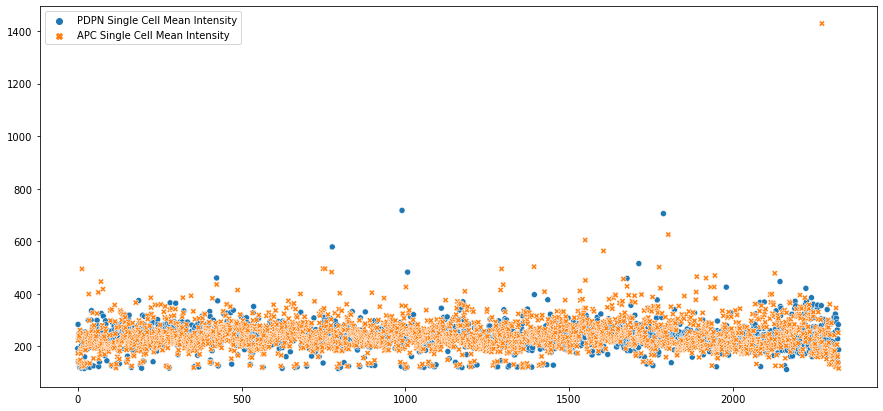

In [18]:
sns.scatterplot(data = mean_int_dict)

Text(0, 0.5, 'Mean Fluorescence Intensity')

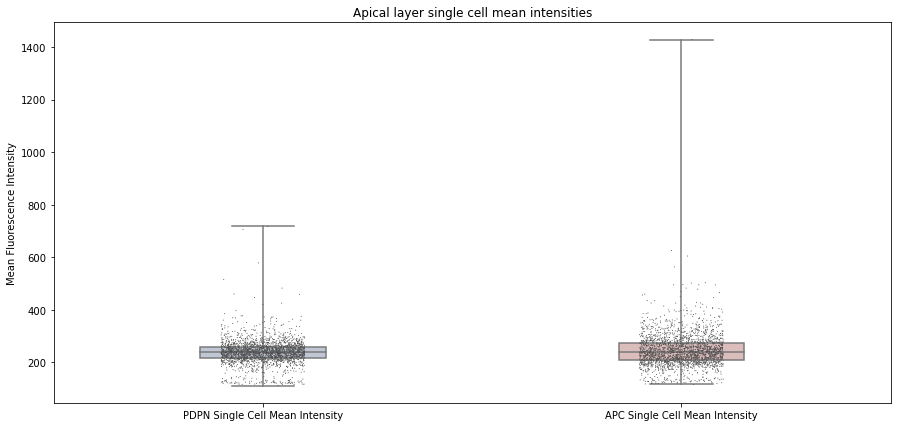

In [26]:
sns.stripplot(data=mean_int_dict,
              size=1, color=".3", linewidth=0)
# Plot the orbital period with horizontal boxes
sns.boxplot(data=mean_int_dict,
            whis=[0, 100], width=0.3, palette="vlag")
plt.title('Apical layer single cell mean intensities')
plt.ylabel('Mean Fluorescence Intensity')

### Visualise the data

In [27]:
visualise_pdpn_final_tracks, properties, graph = btrack.utils.tracks_to_napari(pdpn_tracks_final, ndim=2)
visualise_spc_final_tracks, properties, graph = btrack.utils.tracks_to_napari(spc_tracks_final, ndim=2)

In [28]:
viewer = napari.Viewer()

viewer = napari.Viewer()
viewer.add_image(dapi, colormap='blue', blending = 'additive')
viewer.add_image(zo1, colormap= 'yellow', blending = 'additive')
viewer.add_image(spc, colormap='green', blending = 'additive')
viewer.add_image(pdpn, colormap= 'red', blending = 'additive')

#viewer.add_labels(basal_mask_stack)
viewer.add_labels(apical_mask_stack)

viewer.add_tracks(visualise_pdpn_final_tracks, name = 'pdpn')
viewer.add_tracks(visualise_spc_final_tracks, name = 'spc')

Assistant skips harvesting pyclesperanto as it's not installed.


/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)
/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/napari_tools_menu/__init__.py:194: FutureWarning: Public access to Window.qt_viewer is deprecated and will be removed in
v0.5.0. It is considered an "implementation detail" of the napari
application, not part of the napari viewer model. If your use case
requires access to qt_viewer, please open an issue to discuss.
  self.tools_menu = ToolsMenu(self, self.qt_viewer.viewer)


<Tracks layer 'spc [1]' at 0x7fa287b44f70>

### example positive pdpn track

In [37]:
[track for track in pdpn_tracks_final if track.ID == 2543][0]

OrderedDict([('ID', 2543), ('t', [28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]), ('x', [904.6838764201408, 905.5217279934425, 904.8223466186654, 905.2800668958661, 904.6902305671363, 904.5071259380163, 904.590022846208, 904.9736798957945, 904.9277277806956, 904.8507295454972, 904.9092628689403, 904.468011610768, 904.886358206694, 905.3266128533475, 905.4703109105191, 905.1573438109738, 904.2670785890243, 904.3898982961186, 904.5822917408776, 905.7621083074516]), ('y', [775.22167161255, 773.7877470254485, 773.0142183053528, 772.3186821721481, 771.6783776107443, 771.909447839328, 772.4474439584473, 772.7603044187169, 772.993460671229, 772.9969109334802, 772.7384597640165, 772.5152359680613, 772.168558001585, 772.5140857943558, 772.3428063714443, 772.604892803489, 773.4383446039525, 773.0697102463248, 772.4580500122695, 773.4254994065781]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 2543), ('root', 2543), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]), ('axis_minor_length', array([31.18445802, 40.12621144, 45.28017743, 43.44251081, 42.55736759,
       41.80887129, 41.29914215, 41.09937995, 40.88626689, 40.81370445,
       41.39148135, 40.03215109, 41.26528242, 42.23796502, 41.3860422 ,
       43.93247577, 44.90430358, 45.7158474 , 44.81297426, 34.99535193])), ('area', array([ 913, 1351, 1637, 1617, 1612, 1586, 1519, 1478, 1458, 1462, 1448,
       1388, 1540, 1658, 1546, 1686, 1773, 1821, 1762, 1133])), ('mean_intensity', array([114.04928806, 115.58697261, 117.420281  , 119.44094001,
       122.31141439, 126.70617907, 134.85714286, 148.55615697,
       173.68792867, 218.54582763, 299.38190608, 398.36815562,
       445.75584416, 438.82810615, 401.85769728, 354.1405694 ,
       305.42921602, 257.44755629, 215.08910329, 194.09620477])), ('eccentricity', array([0.55479243, 0.35974662, 0.23258687, 0.43268109, 0.50074199,
       0.53789526, 0.51473094, 0.48461277, 0.47405506, 0.48310195,
       0.41967304, 0.46955636, 0.5312591 , 0.56405391, 0.52689933,
       0.47800678, 0.48931845, 0.45815819, 0.45791692, 0.53475105])), ('axis_major_length', array([37.48182443, 43.00542306, 46.55697327, 48.18662656, 49.16535962,
       49.59465239, 48.17059187, 46.98528292, 46.43553639, 46.61418182,
       45.6016365 , 45.34153106, 48.70730005, 51.15177802, 48.69360315,
       50.0167    , 51.48954998, 51.43138223, 50.40857915, 41.41414439])), ('orientation', array([ 0.0947897 ,  0.03487542, -0.09383499,  0.26101045,  0.32978459,
        0.45392238,  0.51132205,  0.34346978,  0.2806975 ,  0.36980111,
        0.52525046,  0.17627347,  0.38325778,  0.45826565,  0.48650718,
        0.35892945,  0.45303987,  0.4607    ,  0.45202176, -0.6047985 ]))])

In [49]:
[track for track in pdpn_tracks_final if track.ID == 2152][0]

OrderedDict([('ID', 2152), ('t', [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]), ('x', [661.8691700935126, 661.8121493410874, 662.6100322005262, 662.7696050556627, 662.3055485014345, 662.3636399396195, 662.2081845103778, 661.7162464781129, 661.4436424322997, 661.5793217356347, 661.5779542311639, 661.4369539210954, 661.9376472419875, 661.9631173188171, 662.0729427183855, 665.5522806236511]), ('y', [1024.4902023912312, 1024.0610387270344, 1023.6539061534205, 1024.0832742216307, 1024.2692014674974, 1024.2731577317002, 1024.3548583979127, 1024.3406017420498, 1024.147599663652, 1024.1024507628767, 1024.0913261925887, 1024.1167384285034, 1024.187790527582, 1023.4667948590832, 1023.8994981911542, 1024.463049348186]), ('z', [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]), ('parent', 2152), ('root', 2152), ('state', [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5]), ('generation', 0), ('dummy', [False, False, False, False, False, False, False, False, False, False, False, False, False, False, False, False]), ('axis_minor_length', array([34.17332311, 37.90376473, 37.33737149, 35.55716335, 36.1223133 ,
       35.99343189, 35.19558037, 35.32873894, 35.56681032, 35.91435832,
       35.271913  , 35.58903836, 34.30282506, 34.75879023, 35.64032715,
       34.98455079])), ('area', array([1083, 1248, 1271, 1205, 1217, 1206, 1187, 1176, 1179, 1195, 1172,
       1171, 1143, 1289, 1259, 1015])), ('mean_intensity', array([126.1920591 , 128.96394231, 133.65302911, 141.56099585,
       152.07641742, 168.63764511, 196.00589722, 244.16071429,
       329.84139101, 441.29372385, 516.43259386, 536.09820666,
       511.37095363, 477.28549263, 442.40270056, 407.2       ])), ('eccentricity', array([0.54434449, 0.44345361, 0.52213249, 0.57753379, 0.54757826,
       0.54452878, 0.57836109, 0.55710058, 0.54249207, 0.53590582,
       0.56021564, 0.53561267, 0.59752476, 0.68889957, 0.61973155,
       0.32863215])), ('axis_major_length', array([40.73772851, 42.28927579, 43.77879069, 43.5553777 , 43.1695491 ,
       42.9135839 , 43.14342385, 42.5419356 , 42.33837005, 42.53855724,
       42.5810935 , 42.14394915, 42.77957901, 47.95263021, 45.41245828,
       37.04193395])), ('orientation', array([1.1364503 , 1.15735308, 1.23916644, 1.20398066, 1.28123481,
       1.17789259, 1.17208236, 1.19221853, 1.14545636, 1.17426168,
       1.17787885, 1.25145405, 1.42331361, 1.47958607, 1.4227897 ,
       1.51910499]))])

### Max intensity of each single cell

In [38]:
max_int_dict = pd.DataFrame(columns=['PDPN Single Cell Max Intensity','SPC Single Cell Max Intensity'] )
for n, (pdpn_track, spc_track) in enumerate(zip(pdpn_tracks_final, spc_tracks_final)):
    single_cell_pdpn = max(pdpn_track.properties['mean_intensity'])
    single_cell_spc = max(spc_track.properties['mean_intensity'])
    max_int_dict.loc[n] = [single_cell_pdpn, single_cell_spc]

In [39]:
max_int_dict

PDPN Single Cell Max Intensity  SPC Single Cell Max Intensity
0                         329.030197                     273.378630
1                         605.951496                     414.660469
2                         185.079208                     182.163366
3                         525.092437                     481.487003
4                         488.659919                     419.058415
...                              ...                            ...
2319                      282.929982                     205.891037
2320                      246.593312                     180.875197
2321                      149.949721                     142.444492
2322                      296.145304                     269.135305
2323                      268.320370                     116.737757

[2324 rows x 2 columns]

Text(0, 0.5, 'Max Fluorescence Intensity')

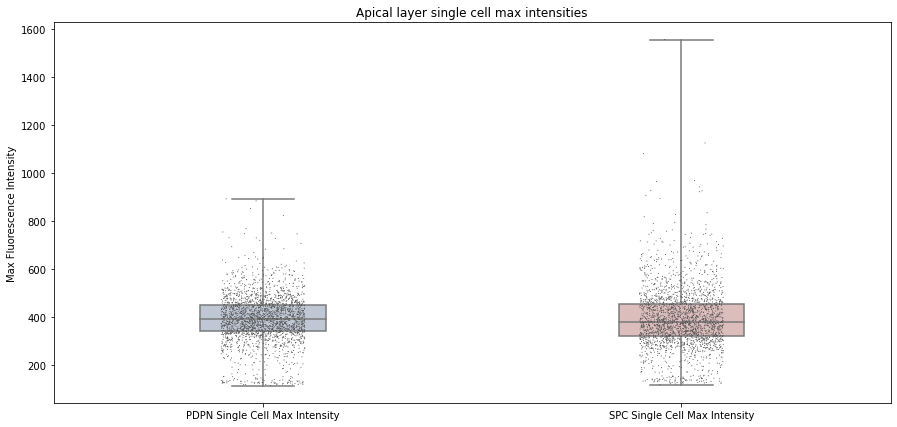

In [42]:
sns.stripplot(data=max_int_dict,
              size=1, color=".3", linewidth=0)
# Plot the orbital period with horizontal boxes
sns.boxplot(data=max_int_dict,
            whis=[0, 100], width=0.3, palette="vlag")
plt.title('Apical layer single cell max intensities')
plt.ylabel('Max Fluorescence Intensity')

Text(0, 0.5, 'Mean intensity of PDPN')

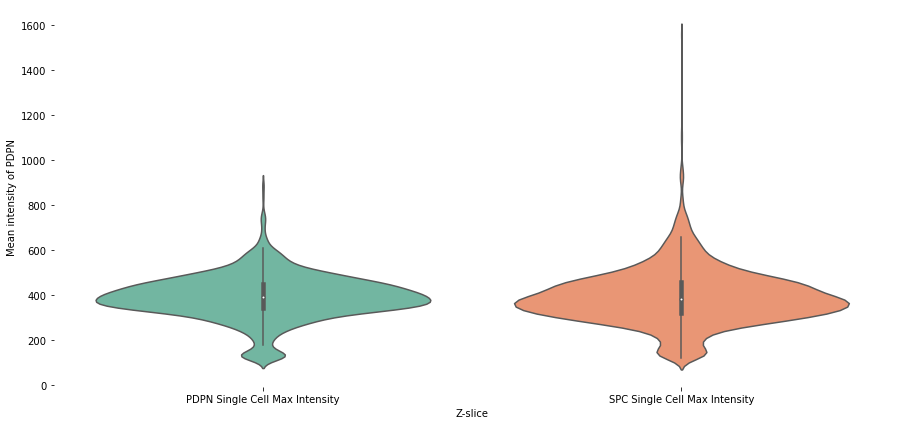

In [43]:
sns.violinplot(data=max_int_dict, palette="Set2", split=True,
                    scale="count", #inner="stick",
                    scale_hue=False, bw=.2)
sns.despine(left=True, bottom=True)
plt.xlabel('Z-slice')
plt.ylabel('Mean intensity of PDPN')

In [50]:
cutoff_pdpn = 200
cutoff_spc = 200

"Positive" PPDN Apical cells

In [48]:
len(max_int_dict[max_int_dict['PDPN Single Cell Max Intensity']>cutoff_pdpn])

2223

"Positive" SPC Apical cells

In [51]:
len(max_int_dict[max_int_dict['SPC Single Cell Max Intensity']>cutoff_spc])

2207

  replacements made: ['viewtransformf', 'raycasting_setup', 'before_loop', 'in_loop', 'after_loop', 'sampler_type', 'post', 'pre', 'clip_with_planes', 'cmap', 'get_data']
Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 903, in paintGL
    self._vispy_canvas.events.draw(region=None)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 218, in on_draw
    self._draw_scene()
  File "/home/dayn/miniconda3/envs/aero

Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 903, in paintGL
    self._vispy_canvas.events.draw(region=None)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 218, in on_draw
    self._draw_scene()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 277, in _draw_scene
    self.draw_visual(self.scene)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-p

Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 903, in paintGL
    self._vispy_canvas.events.draw(region=None)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 218, in on_draw
    self._draw_scene()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 277, in _draw_scene
    self.draw_visual(self.scene)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-p

Traceback (most recent call last):
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/app/backends/_qt.py", line 903, in paintGL
    self._vispy_canvas.events.draw(region=None)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 453, in __call__
    self._invoke_callback(cb, event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 471, in _invoke_callback
    _handle_exception(self.ignore_callback_errors,
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/util/event.py", line 469, in _invoke_callback
    cb(event)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 218, in on_draw
    self._draw_scene()
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-packages/vispy/scene/canvas.py", line 277, in _draw_scene
    self.draw_visual(self.scene)
  File "/home/dayn/miniconda3/envs/aero/lib/python3.9/site-p